In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Veri setinizi yükleyin
df = pd.read_csv('sample_10k.csv')

# Veri ön işleme
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data.values, dtype=torch.float32)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

# Özelliklerinizi ayırın
X = df.drop(columns=['fraud_bool'])  # Özellikler
y = df['fraud_bool']  # Etiketler

# Verileri standardize edin
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Eğitim ve test setlerine ayırın
X_train, X_test, _, _ = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# PyTorch veri yükleyicilerini oluşturun
train_dataset = CustomDataset(pd.DataFrame(X_train))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Basit GAN model tanımlamaları
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.fc(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.fc(x)

# GAN'ı oluşturun
latent_dim = 100
input_dim = X_train.shape[1]

generator = Generator(latent_dim, input_dim)
discriminator = Discriminator(input_dim)

criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# GAN eğitimi
num_epochs = 20
for epoch in range(num_epochs):
    for real_data in train_loader:
        batch_size = real_data.size(0)
        real_data = real_data

        # Gerçek ve sahte veriler için etiketler
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        # Discriminator'ı eğitme
        optimizer_d.zero_grad()
        outputs = discriminator(real_data)
        d_loss_real = criterion(outputs, real_labels)
        d_loss_real.backward()

        z = torch.randn(batch_size, latent_dim)
        fake_data = generator(z)
        outputs = discriminator(fake_data.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        d_loss_fake.backward()
        optimizer_d.step()

        # Generator'ı eğitme
        optimizer_g.zero_grad()
        outputs = discriminator(fake_data)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        optimizer_g.step()

    print(f'Epoch [{epoch+1}/{num_epochs}] | D Loss: {d_loss_real.item() + d_loss_fake.item()} | G Loss: {g_loss.item()}')

# Yapay veri üretme
z = torch.randn(1000, latent_dim)
generated_data = generator(z).detach().numpy()
generated_data = scaler.inverse_transform(generated_data)

# Yapay veriyi DataFrame'e dönüştürme
generated_df = pd.DataFrame(generated_data, columns=df.columns[:-1])



Epoch [1/20] | D Loss: 1.3559034073296061e-06 | G Loss: 13.555625915527344
Epoch [2/20] | D Loss: 1.6686635719409537e-05 | G Loss: 11.011651992797852
Epoch [3/20] | D Loss: 2.6063897266226377e-05 | G Loss: 10.56464958190918
Epoch [4/20] | D Loss: 7.357093636528589e-06 | G Loss: 11.829754829406738
Epoch [5/20] | D Loss: 5.224062078923453e-06 | G Loss: 12.166705131530762
Epoch [6/20] | D Loss: 1.9501398363313367e-16 | G Loss: 36.1734619140625
Epoch [7/20] | D Loss: 0.00013432451046924143 | G Loss: 10.316878318786621
Epoch [8/20] | D Loss: 7.473336685603904e-09 | G Loss: 24.50629234313965
Epoch [9/20] | D Loss: 6.258053479585432e-15 | G Loss: 32.70491027832031
Epoch [10/20] | D Loss: 4.2787912969688424e-12 | G Loss: 26.177350997924805
Epoch [11/20] | D Loss: 3.535638768425997e-07 | G Loss: 14.858078956604004
Epoch [12/20] | D Loss: 1.0933173637261984e-11 | G Loss: 25.23921775817871
Epoch [13/20] | D Loss: 2.103297157480307e-15 | G Loss: 33.79527282714844
Epoch [14/20] | D Loss: 6.31588317

In [3]:
generated_df.head()

,name_email_similarity,current_address_months_count,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,...,device_distinct_emails_8w_0,device_distinct_emails_8w_1,device_distinct_emails_8w_2,month_1,month_2,month_3,month_4,month_5,month_6,month_7
0,0.204619,174.931335,6.409934,28.893682,2577.906982,8670.556641,6246.788086,5776.315918,-274.790436,4.469021,...,-0.0727,0.792196,-0.131759,0.461279,0.480841,0.508859,-0.206056,0.443415,-0.202414,0.392652
1,0.204619,174.931335,6.409934,28.893682,2577.906982,8670.556641,6246.788086,5776.315918,-274.790436,4.469021,...,-0.0727,0.792196,-0.131759,0.461280,0.480841,0.508859,-0.206056,0.443413,-0.202414,0.392652
2,0.204619,174.931335,6.409934,28.893682,2577.906982,8670.555664,6246.788086,5776.315918,-274.790436,4.469021,...,-0.0727,0.792196,-0.131759,0.461280,0.480841,0.508859,-0.206056,0.443415,-0.202414,0.392652
3,0.204619,174.931335,6.409934,28.893682,2577.906982,8670.544922,6246.788086,5776.315918,-274.790436,4.469021,...,-0.0727,0.792196,-0.131759,0.461280,0.480841,0.508859,-0.206056,0.443415,-0.202414,0.392652
4,0.204619,174.931335,6.409934,28.893682,2577.906982,8670.556641,6246.788086,5776.315918,-274.790436,4.469021,...,-0.0727,0.792196,-0.131759,0.461280,0.480841,0.508859,-0.206056,0.443415,-0.202414,0.392652


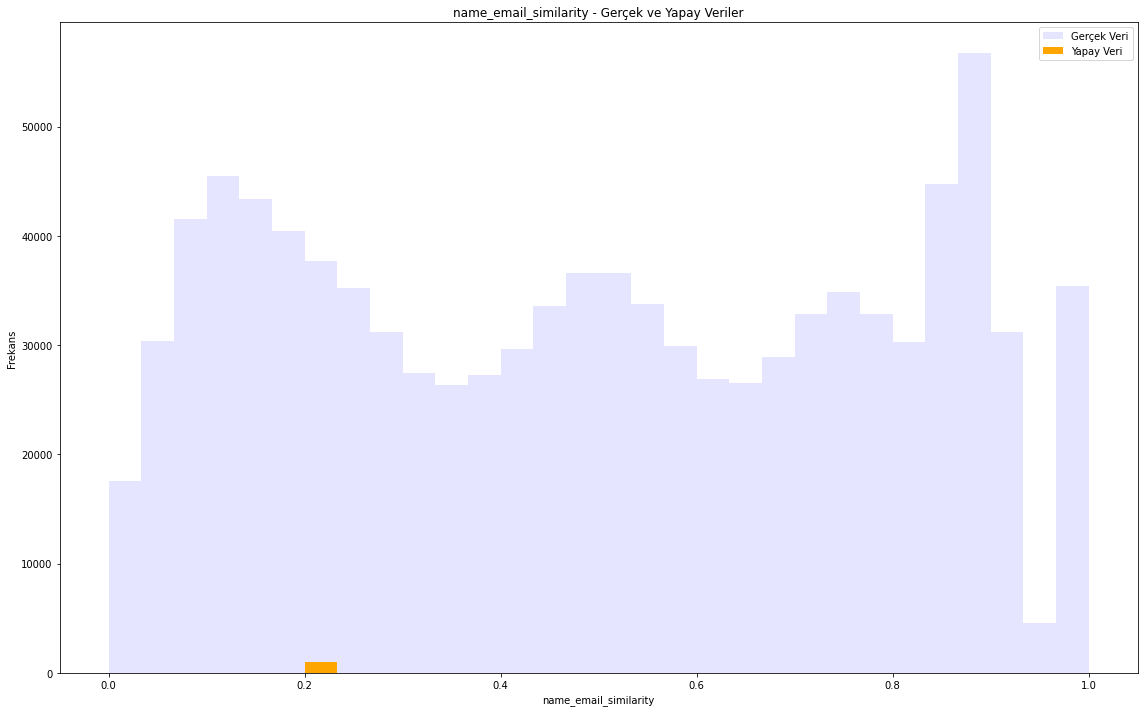

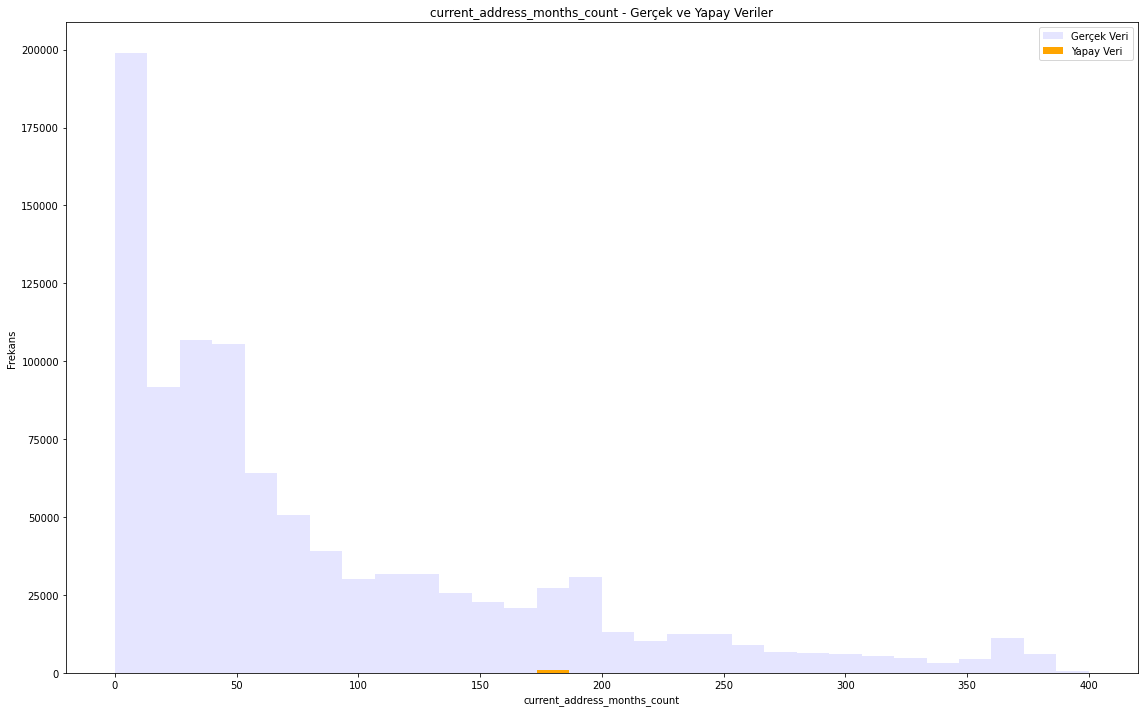

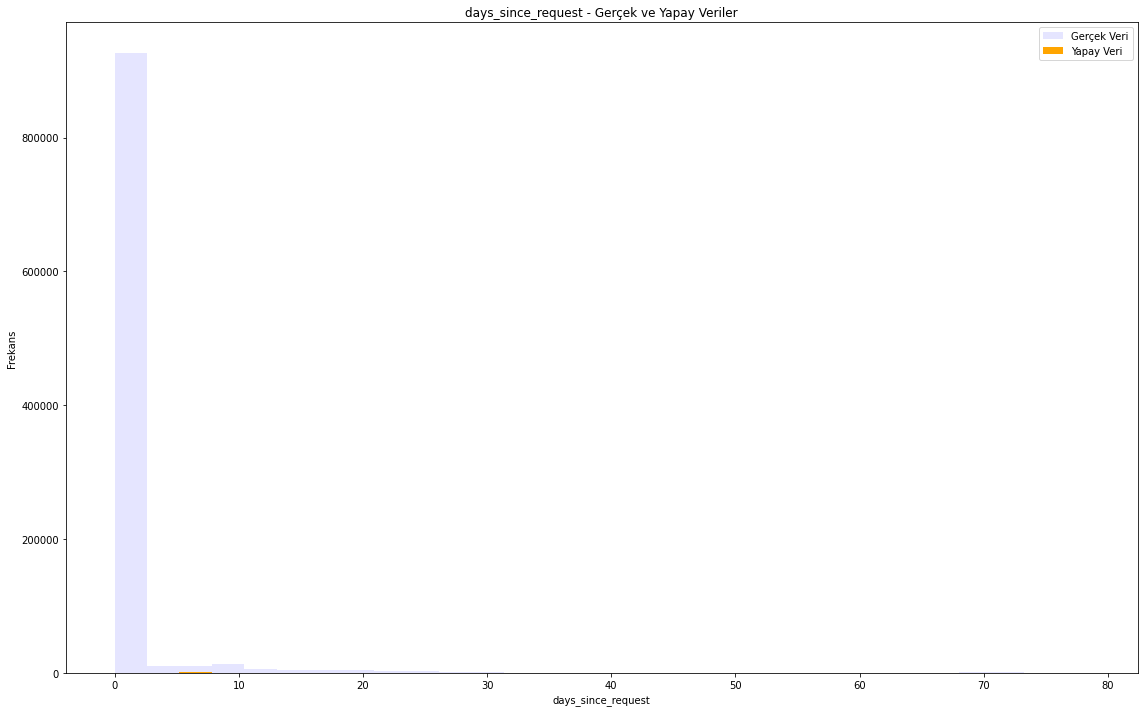

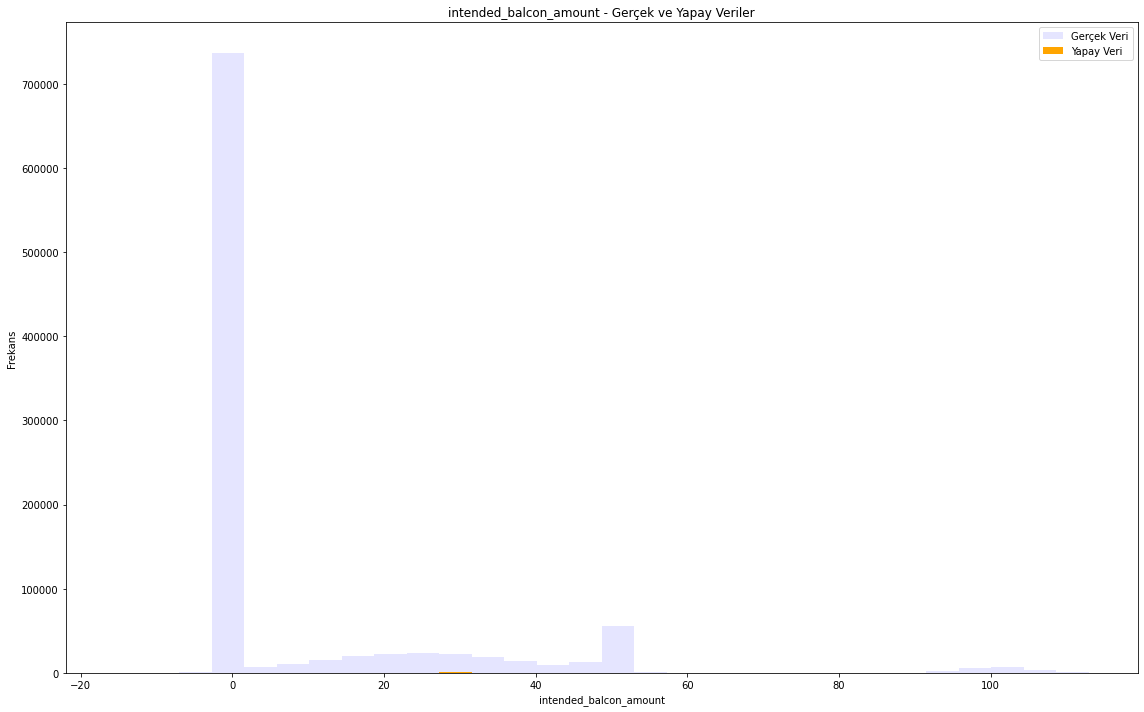

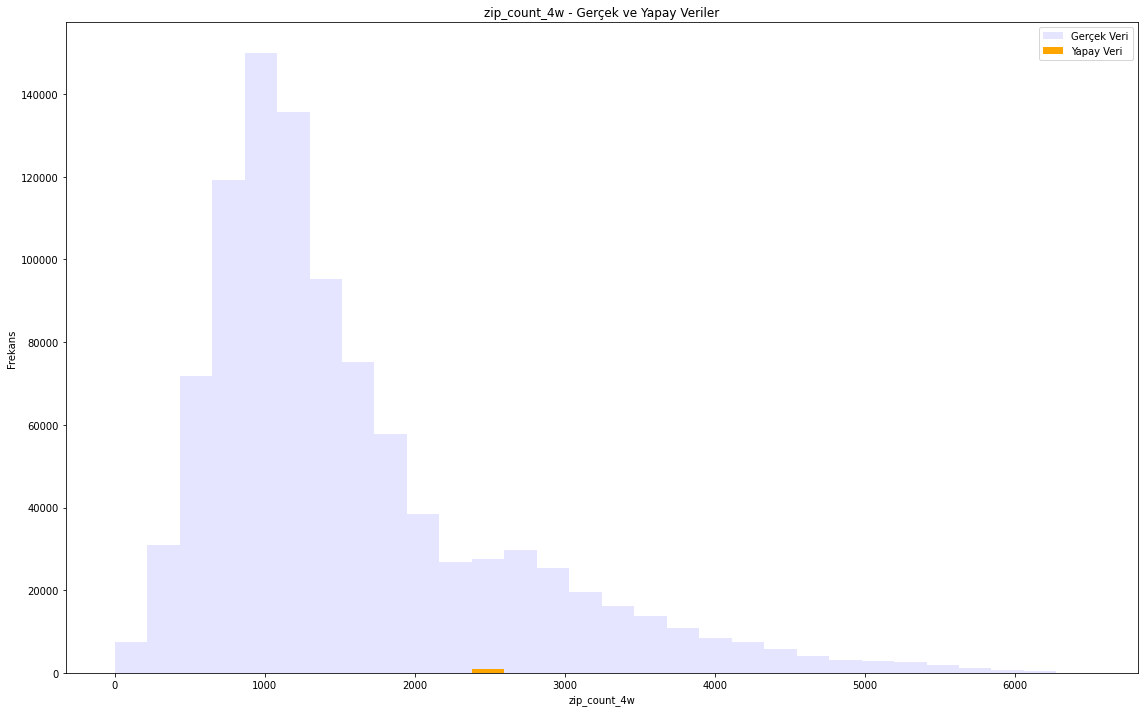

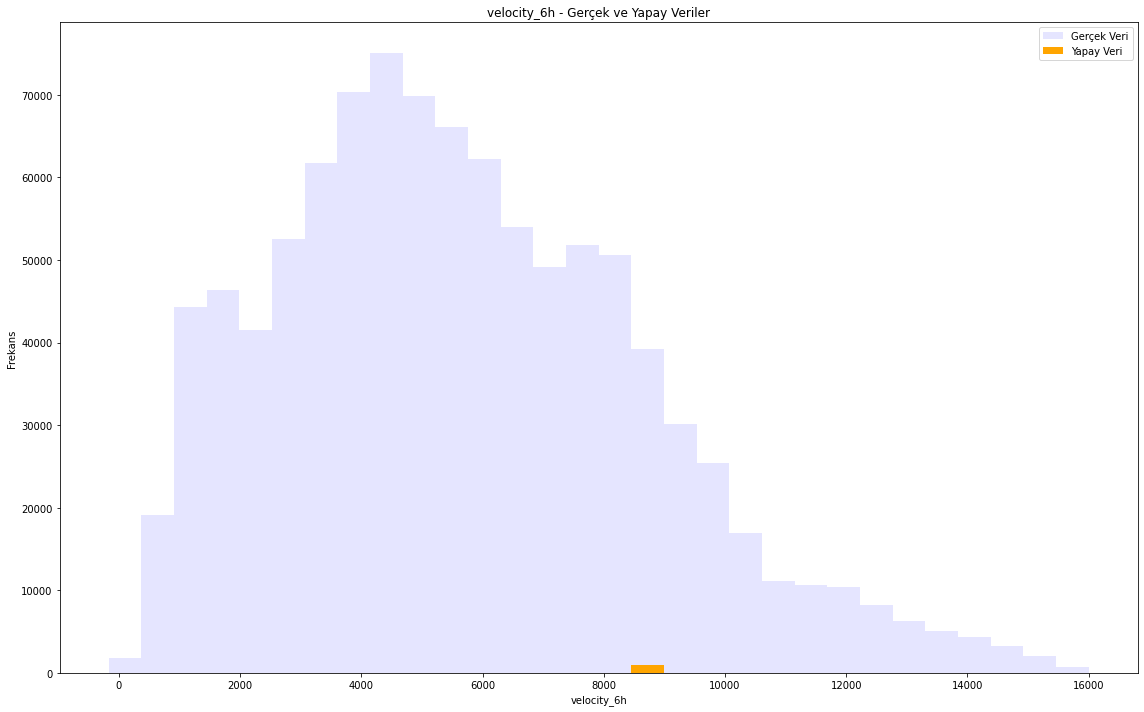

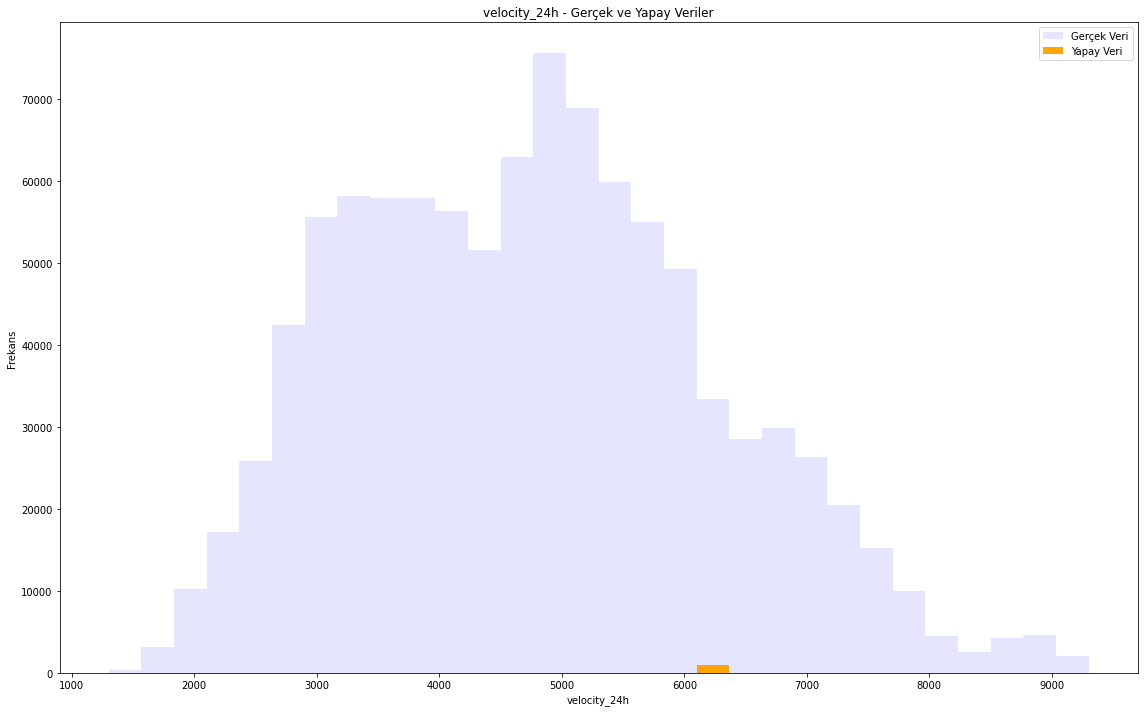

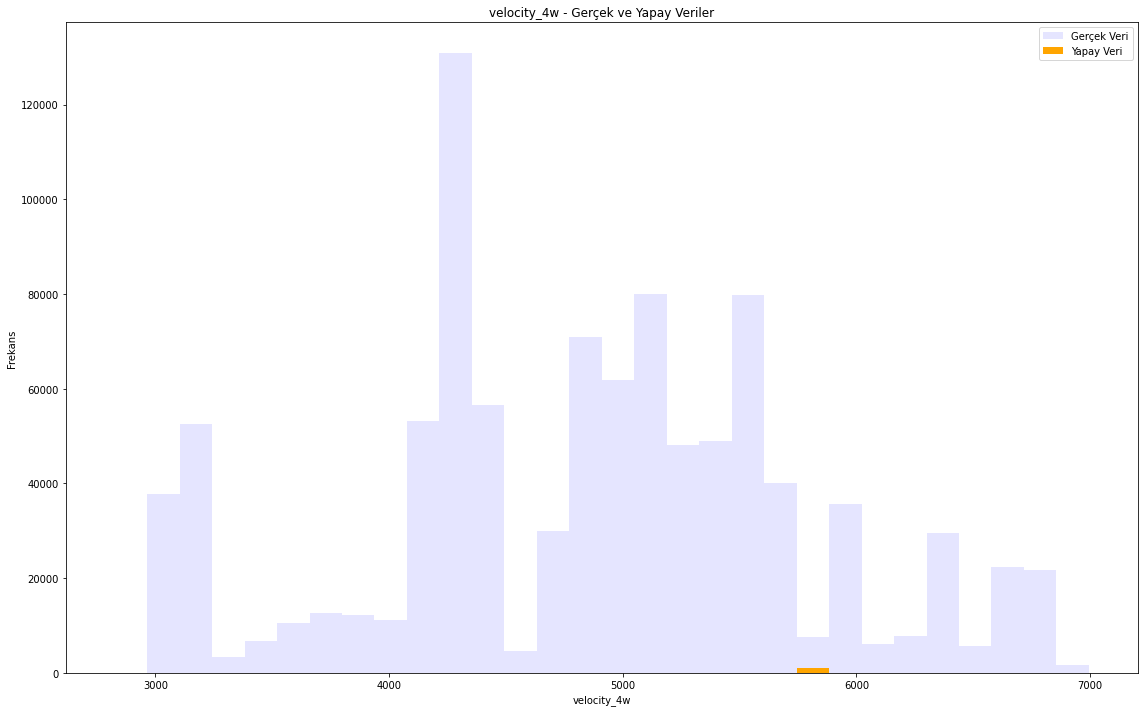

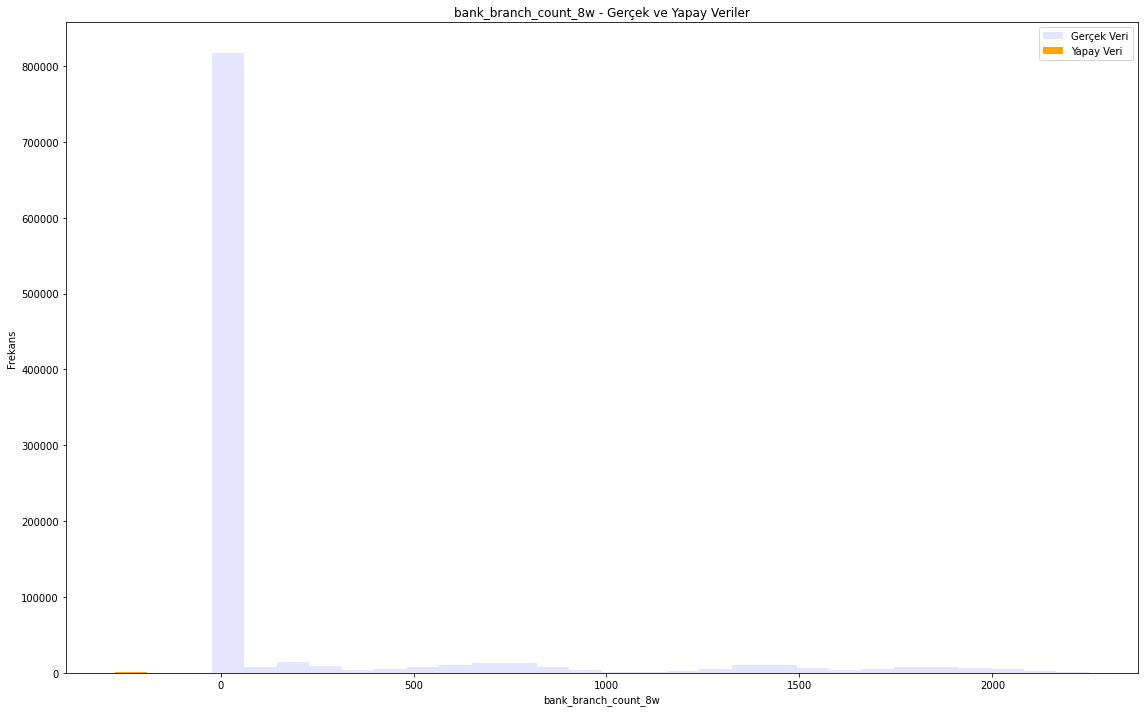

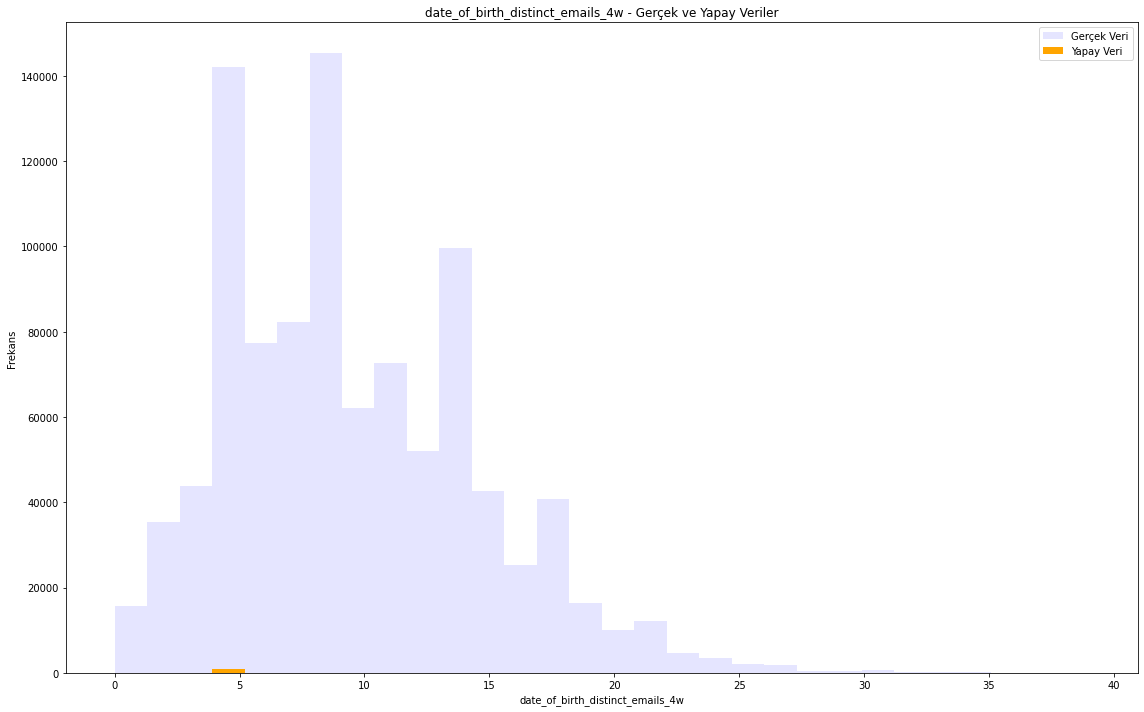

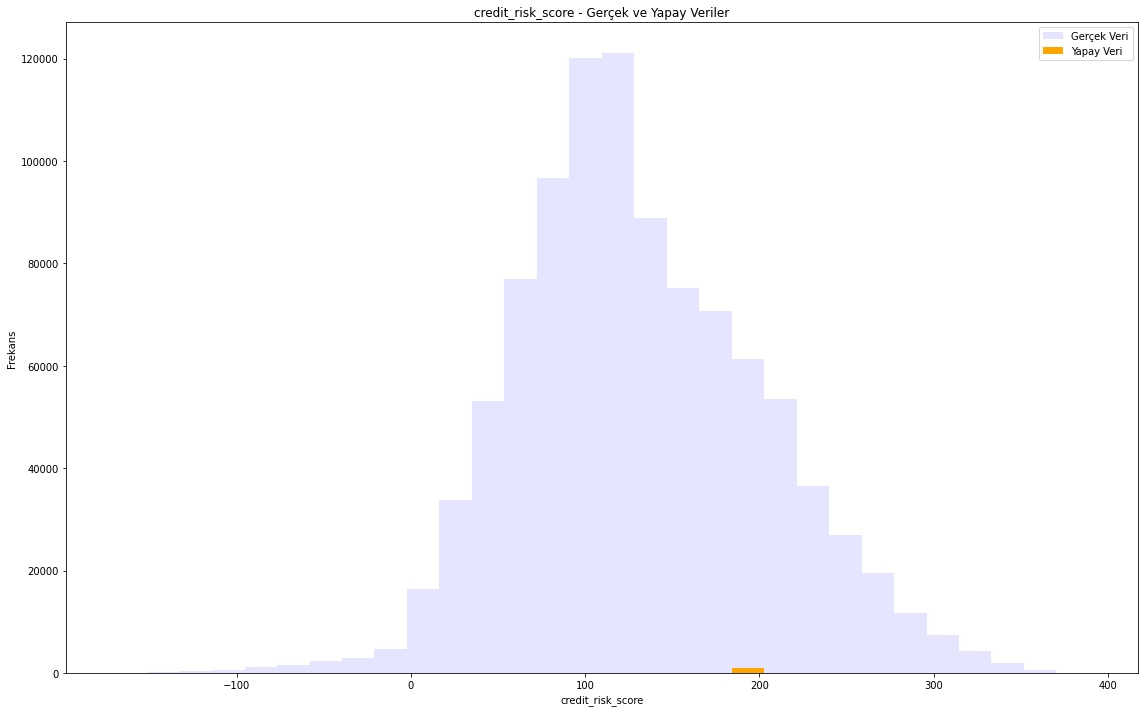

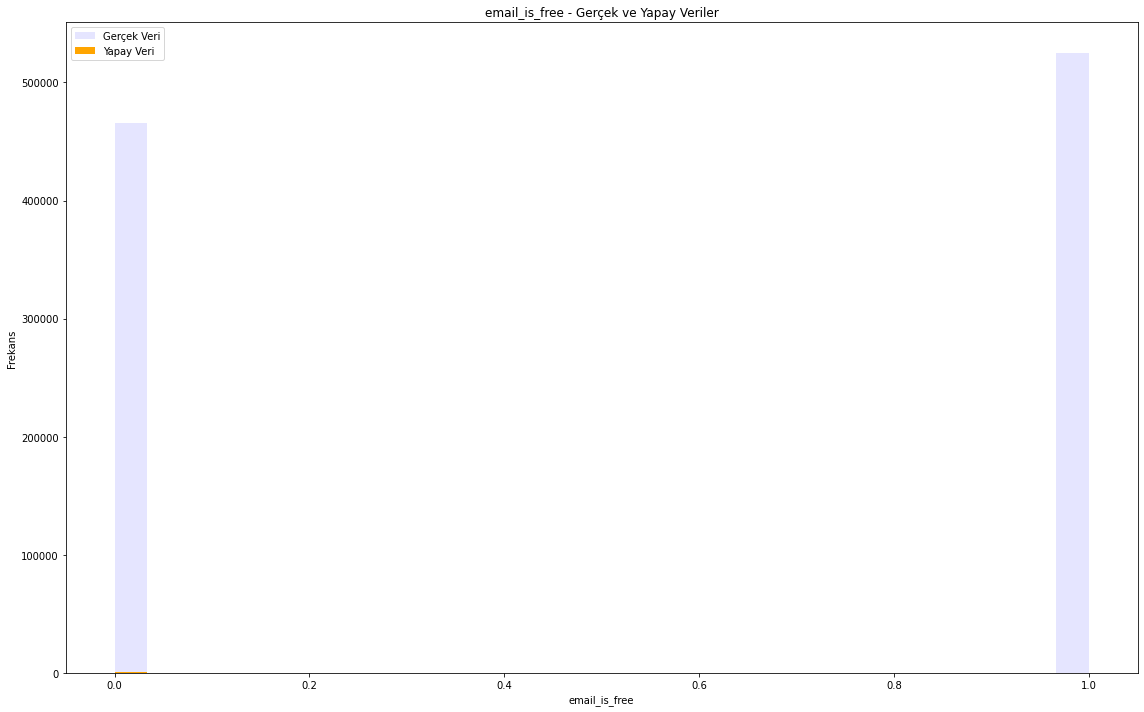

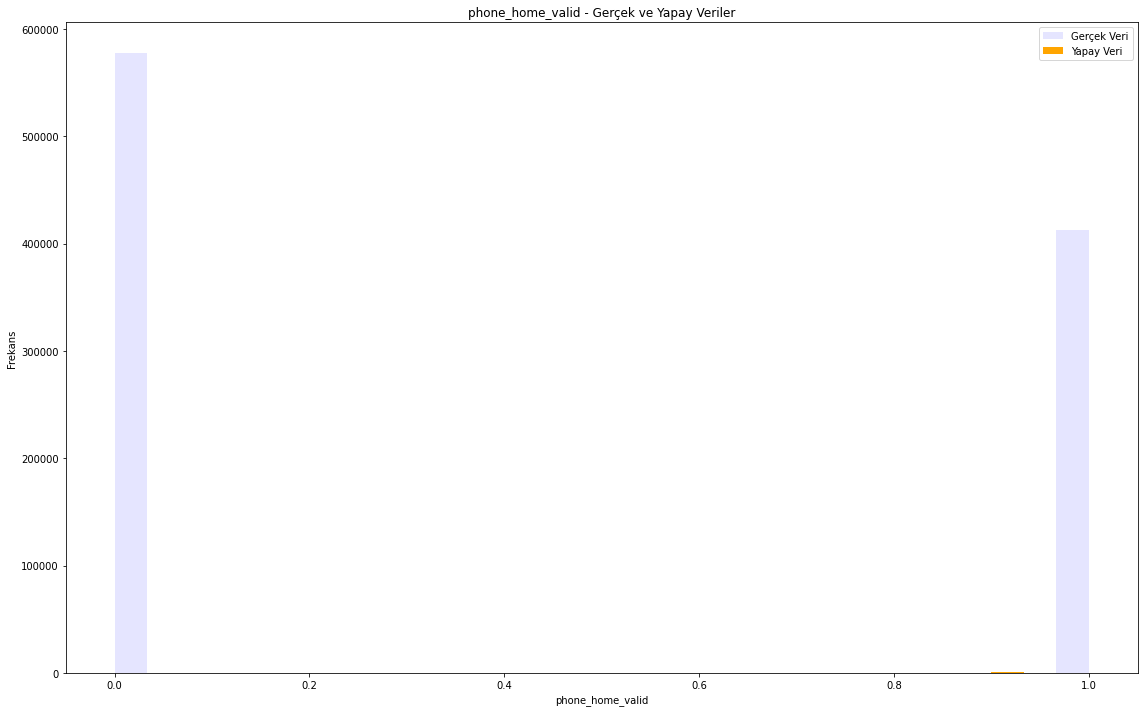

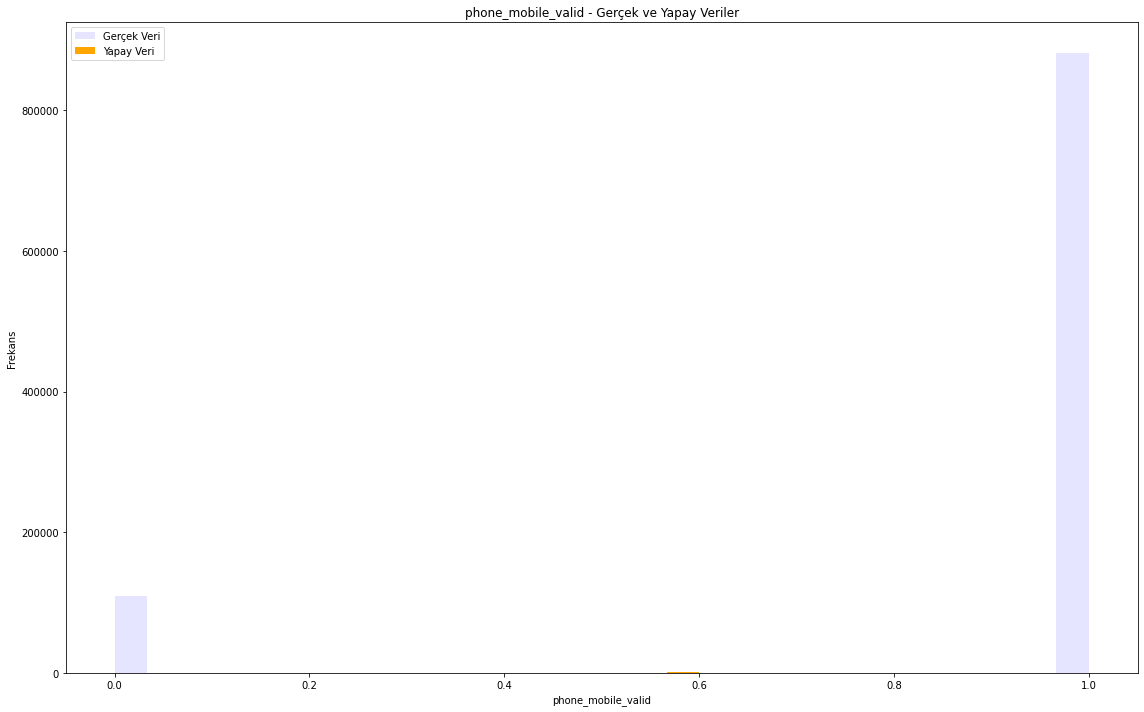

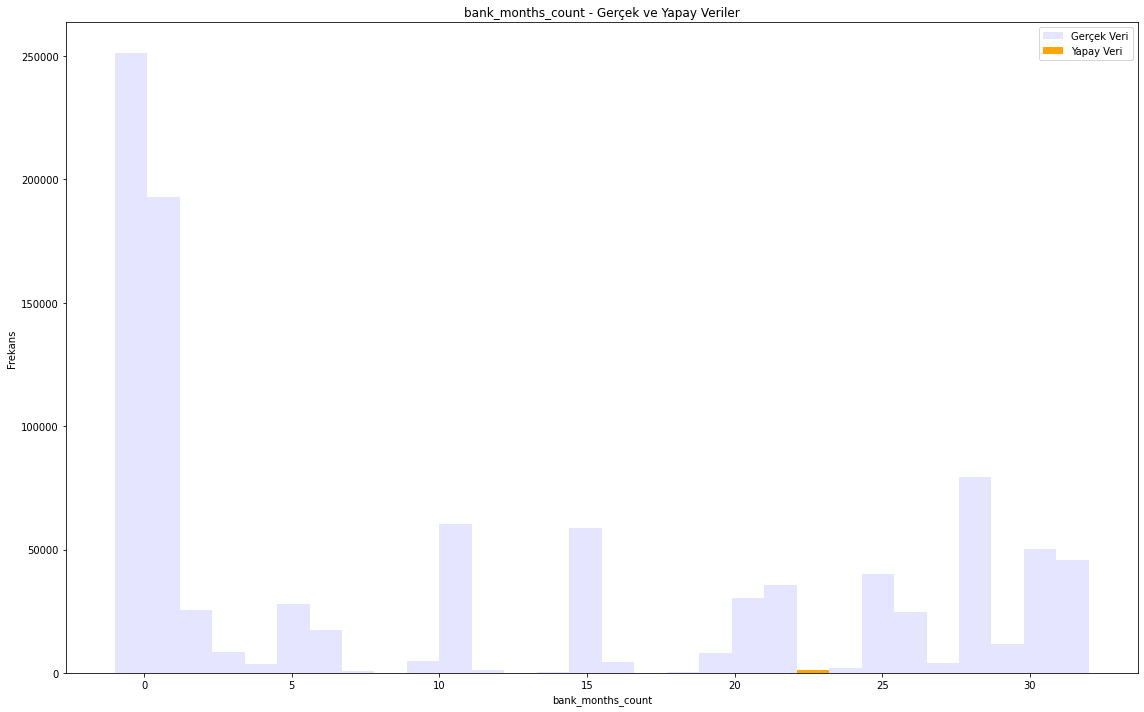

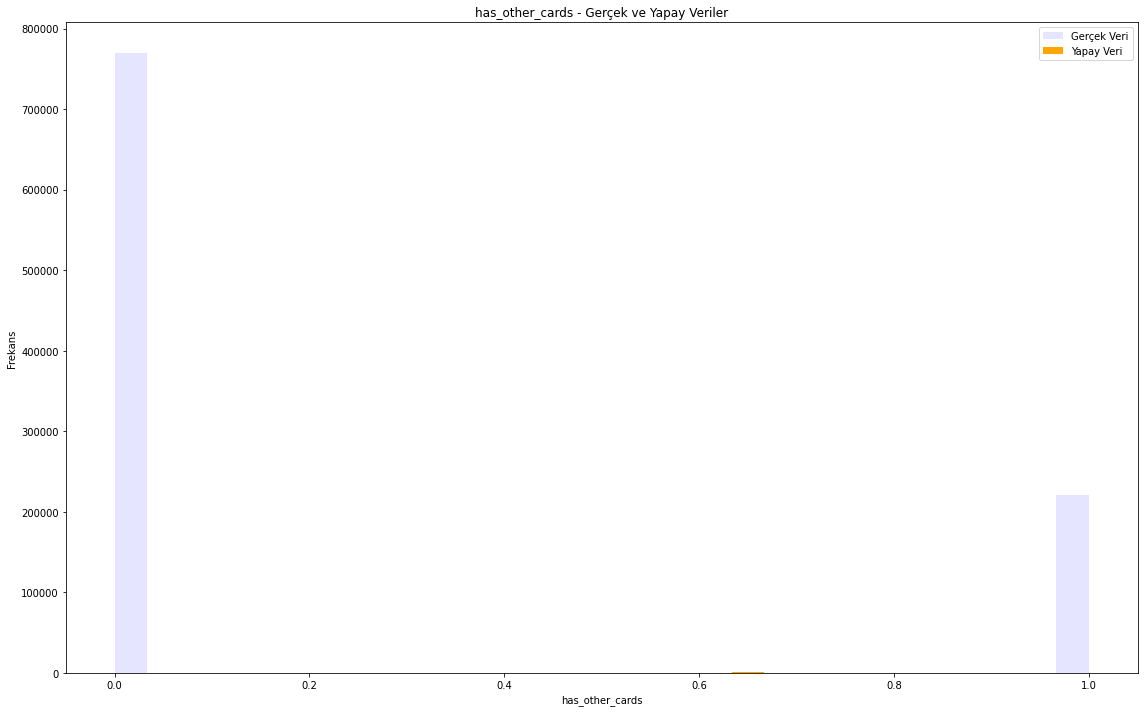

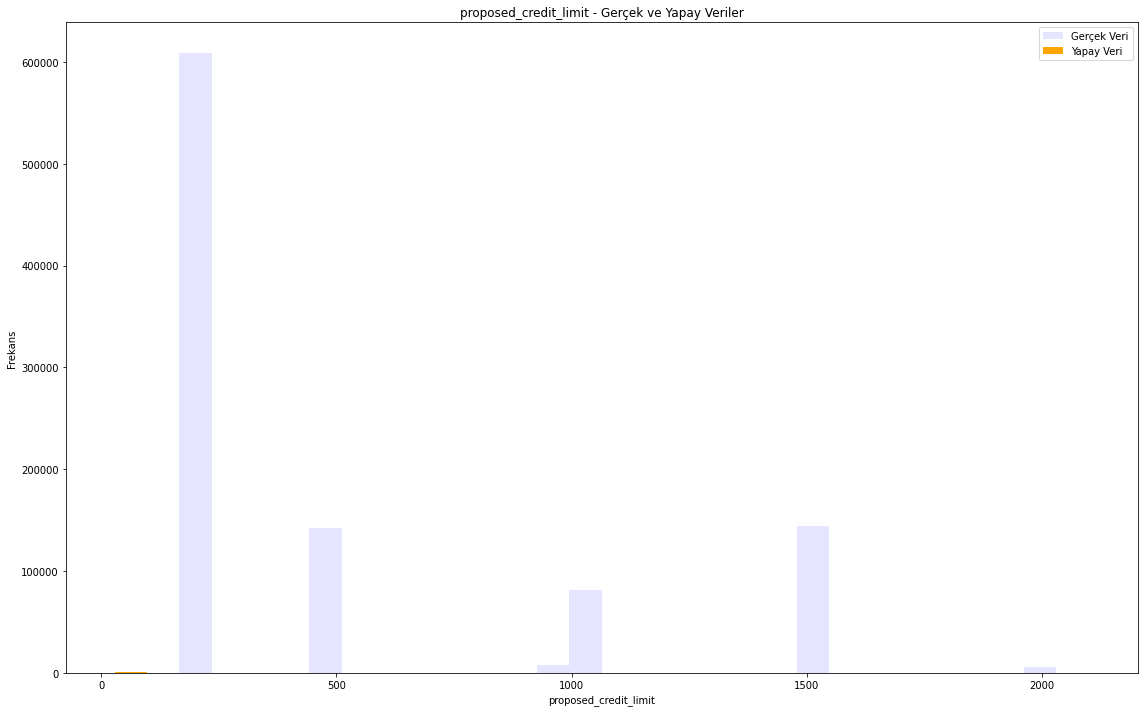

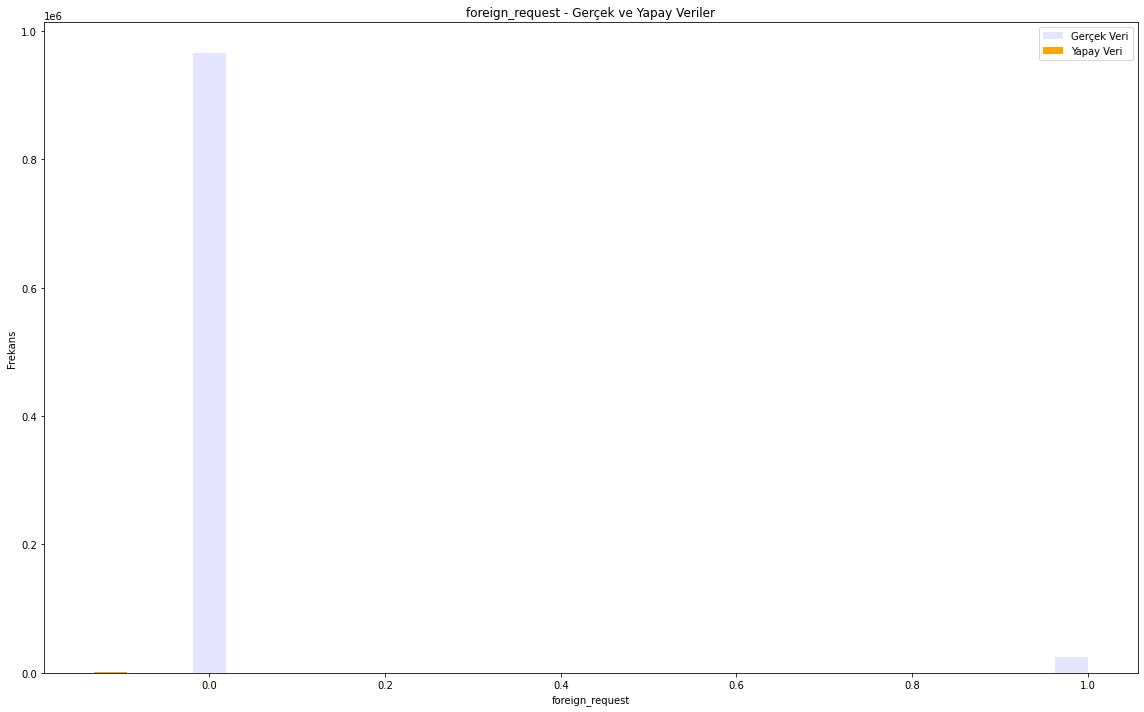

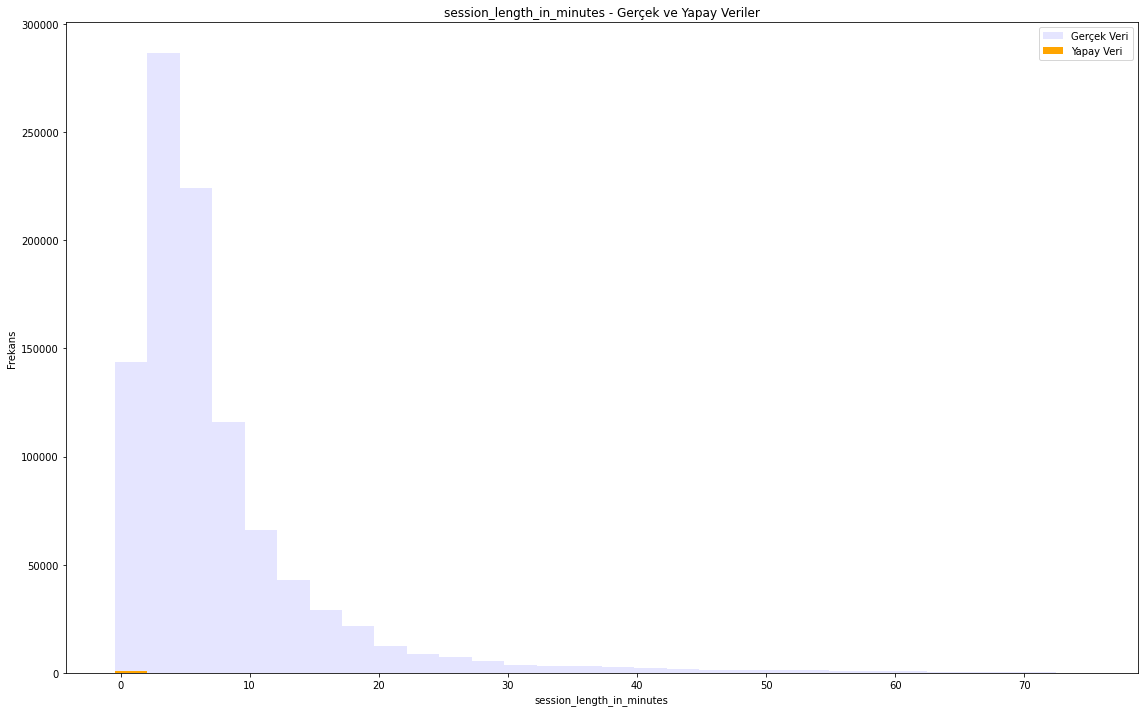

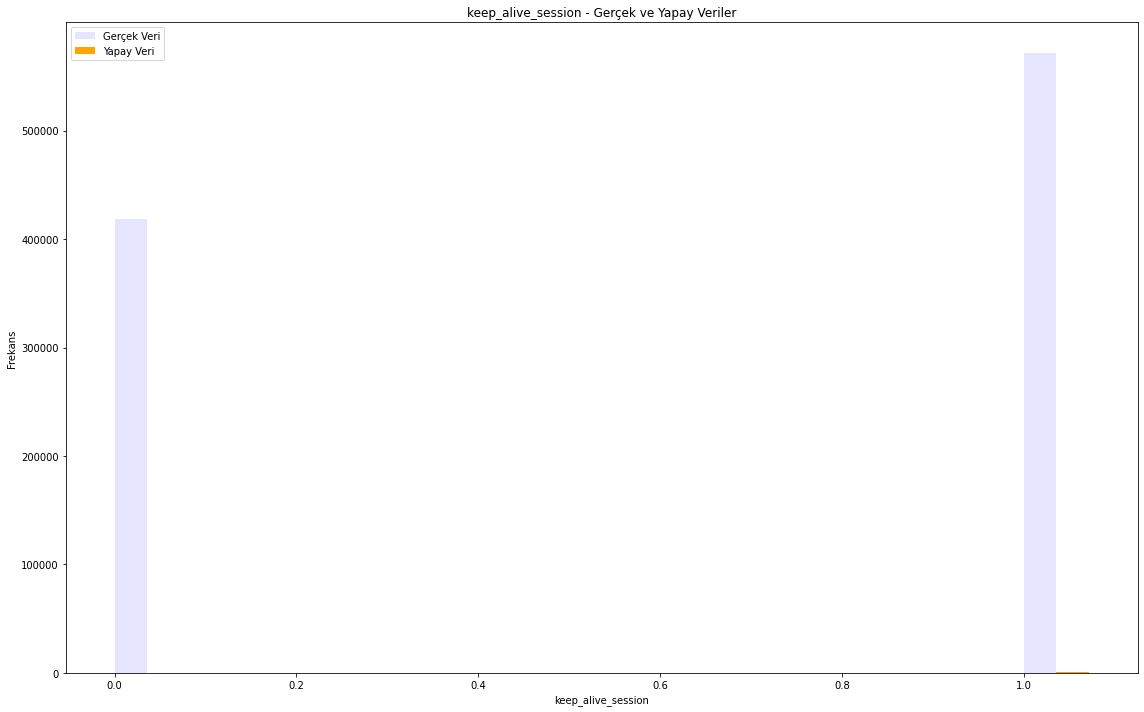

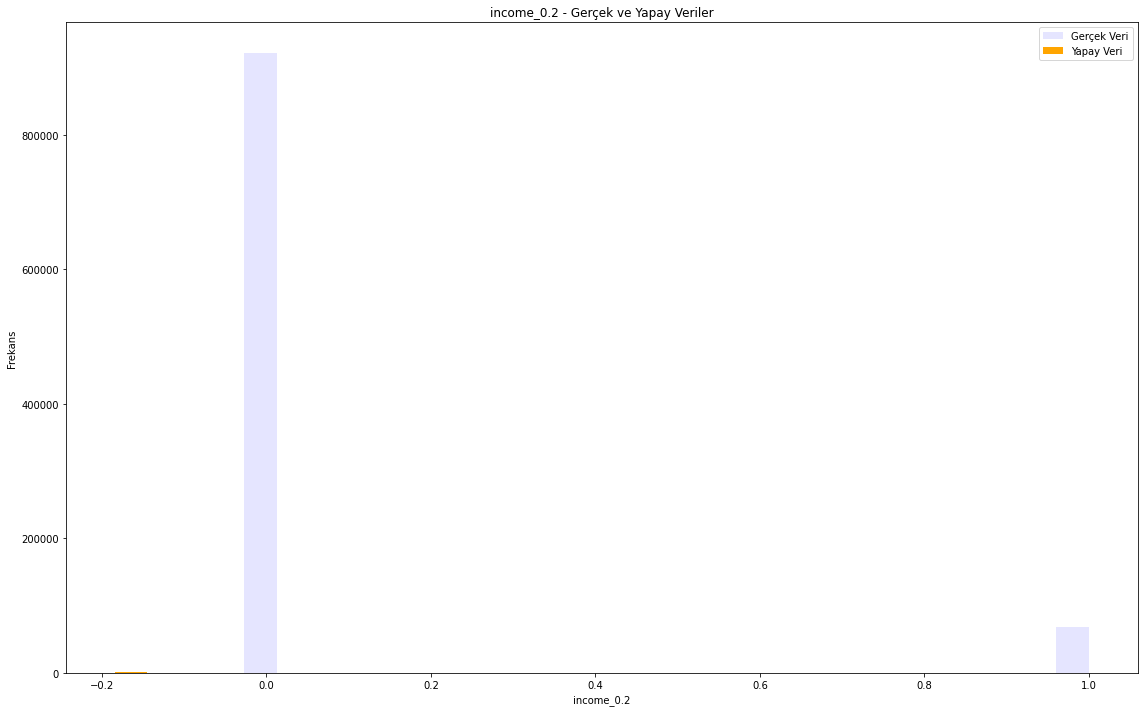

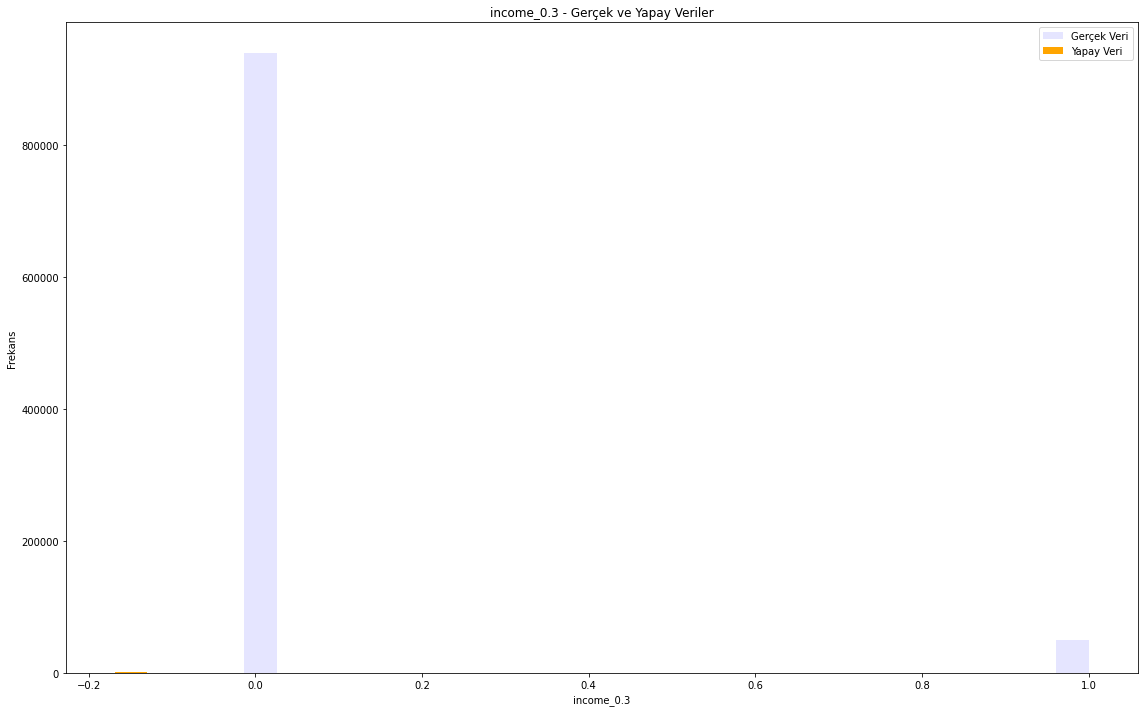

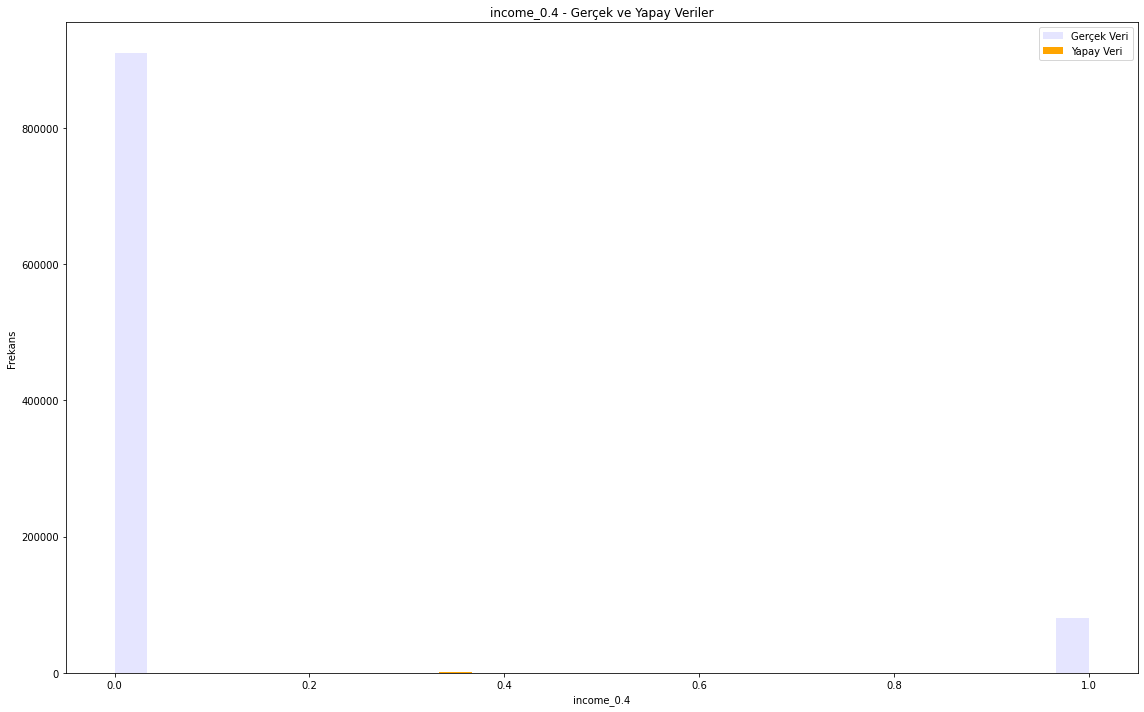

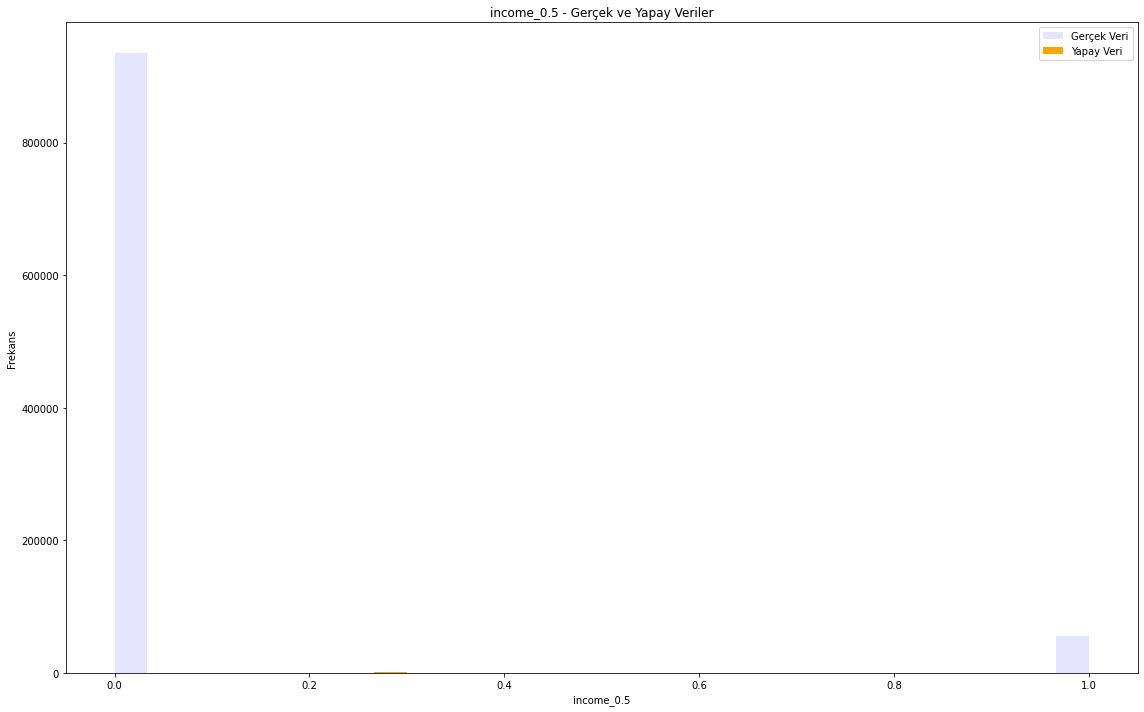

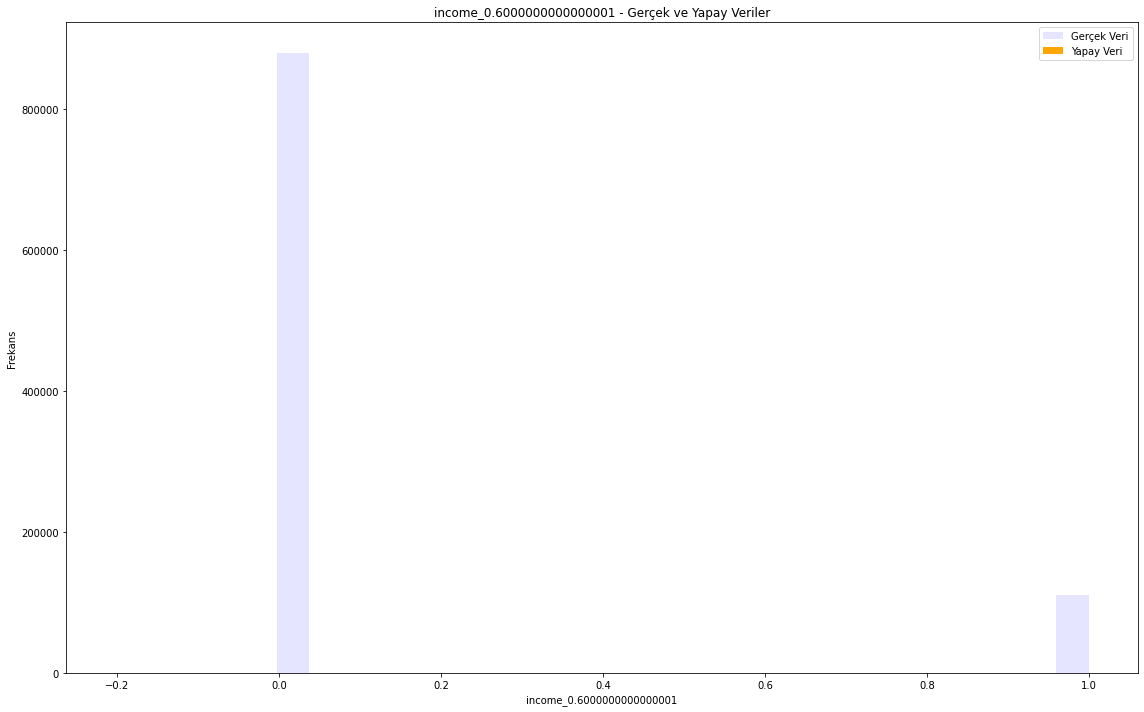

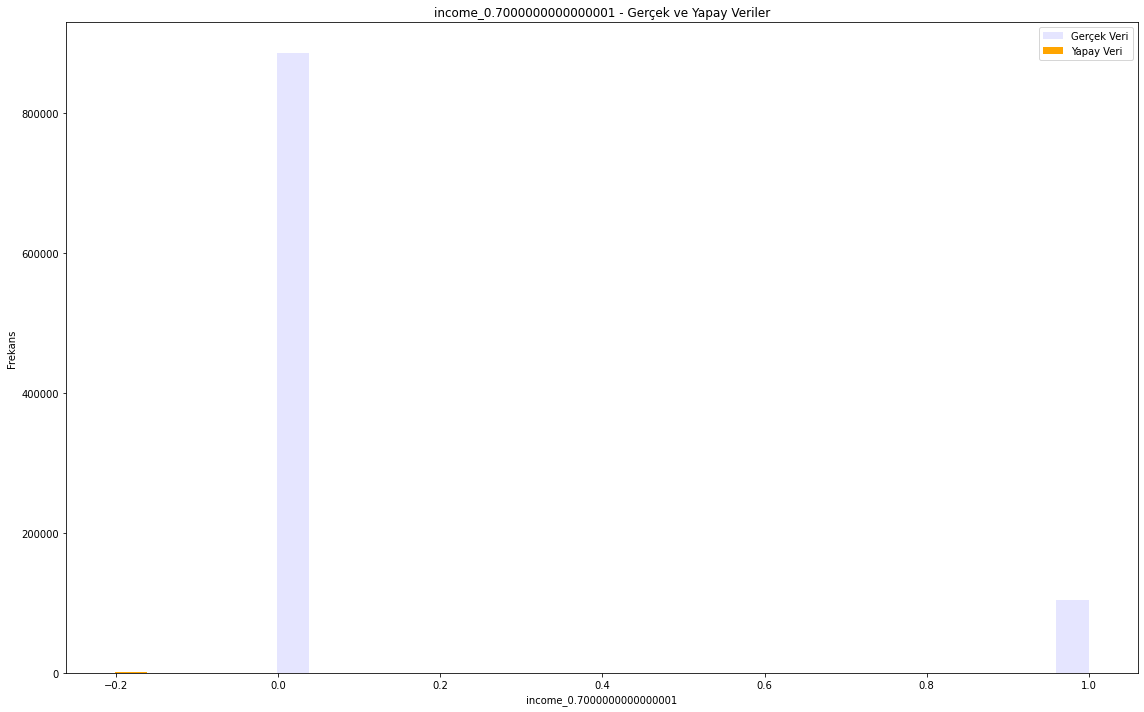

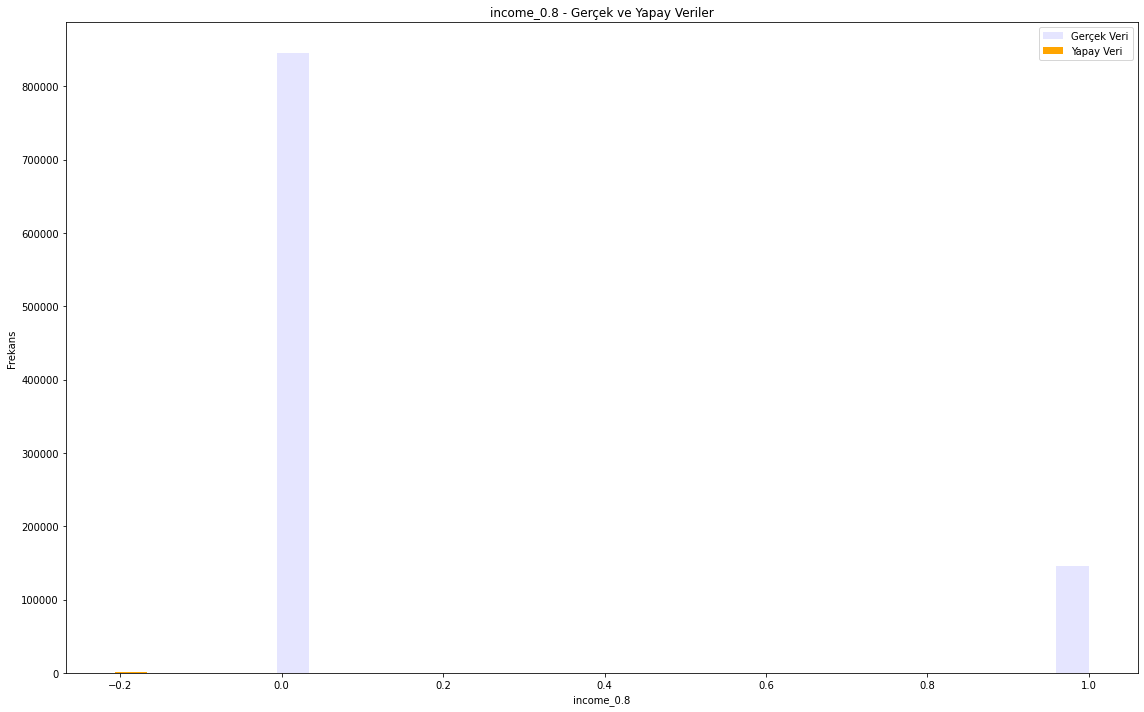

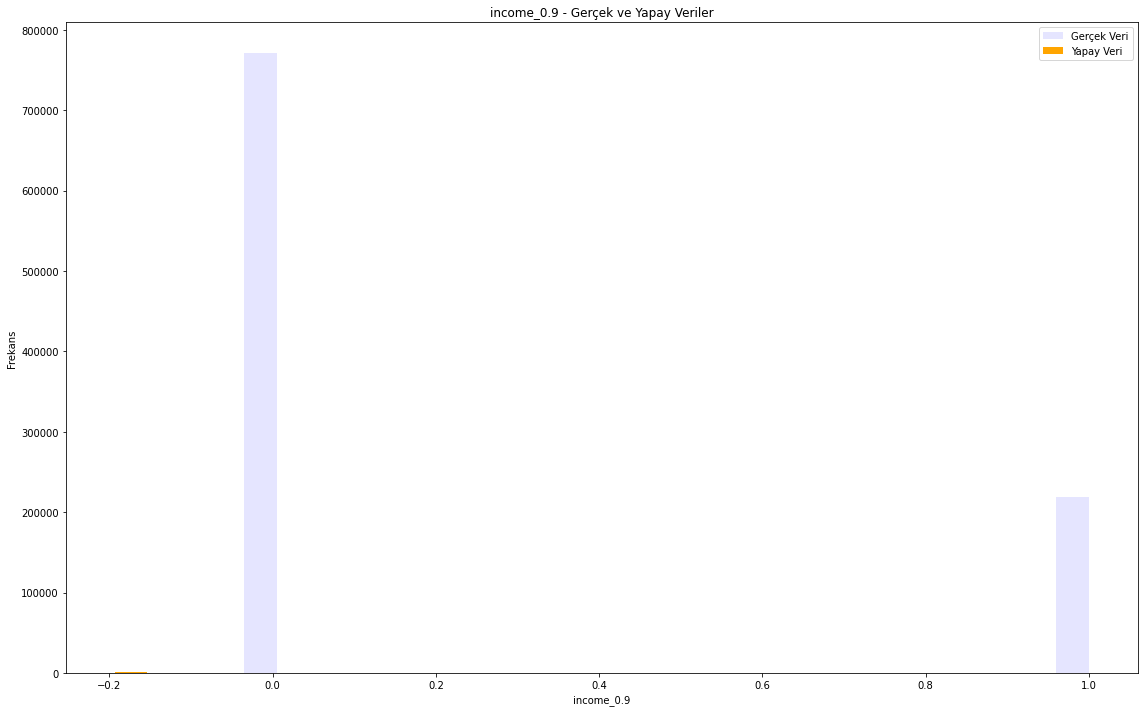

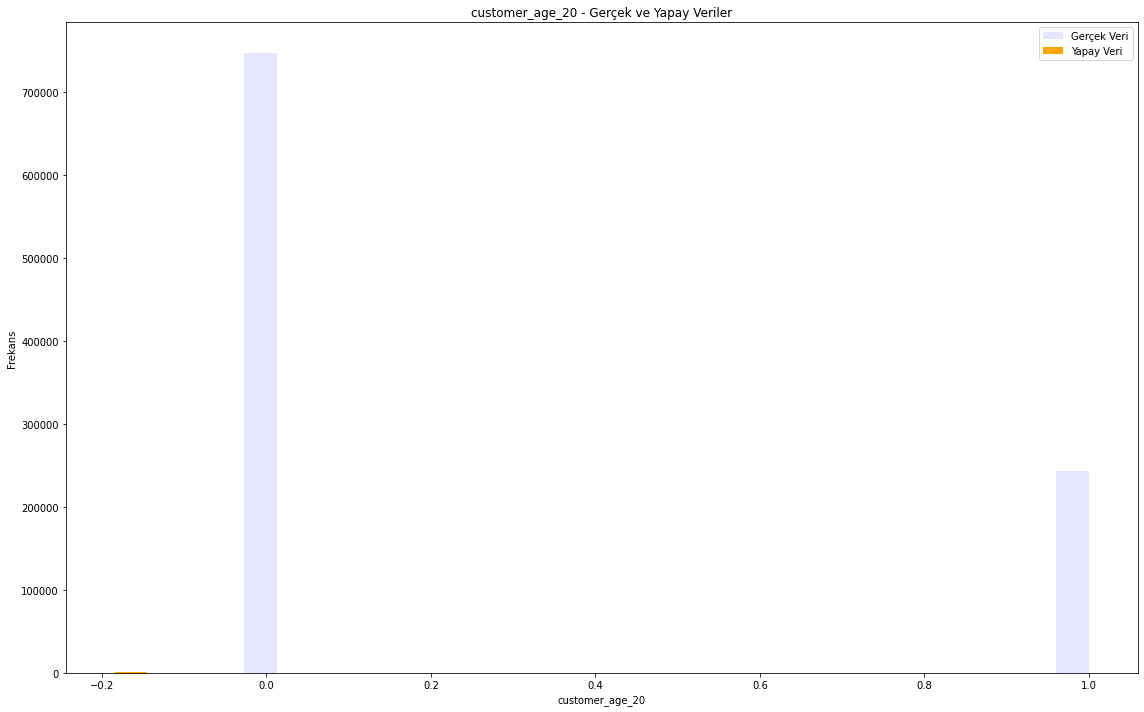

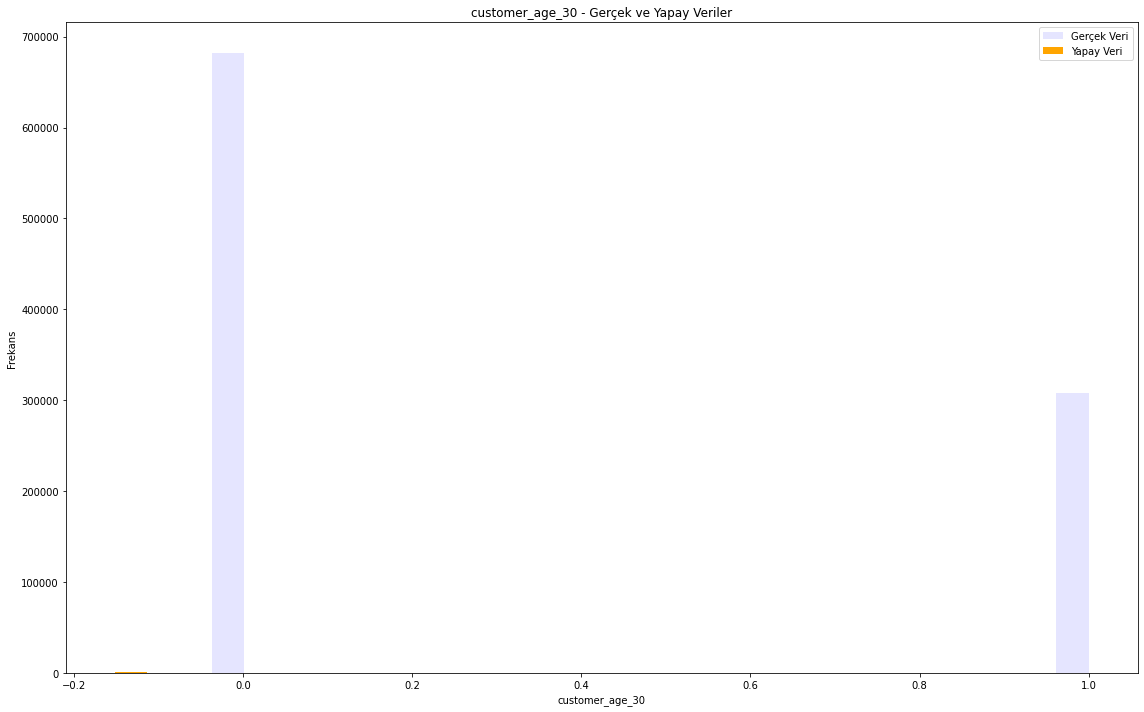

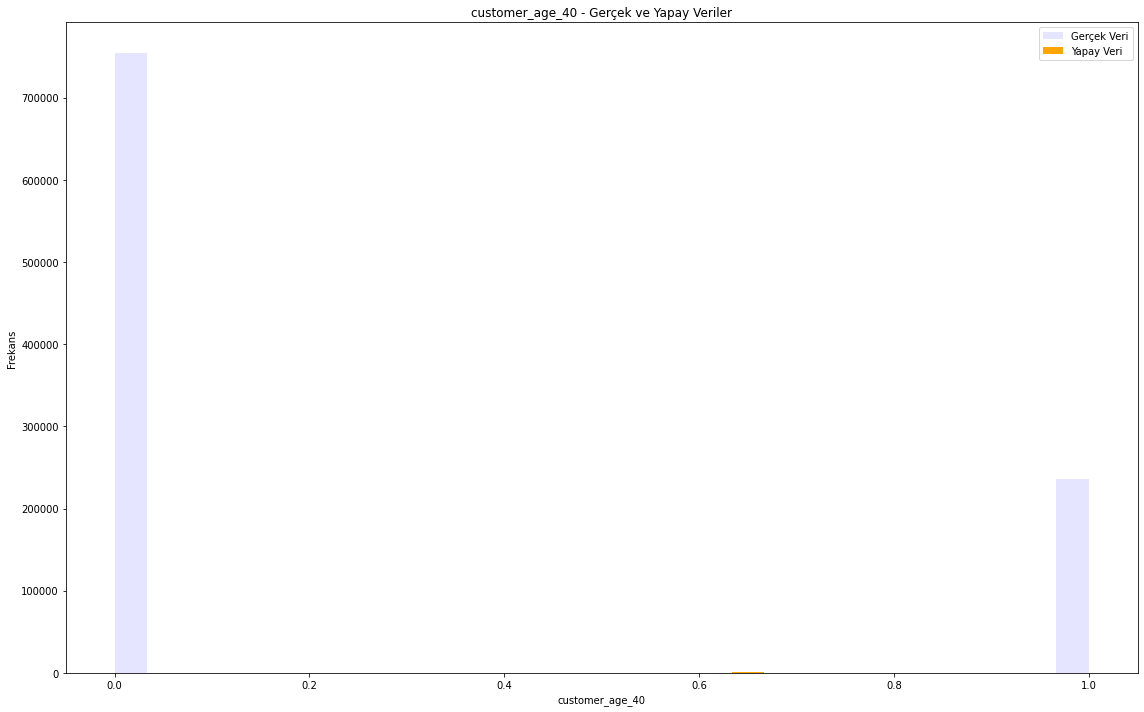

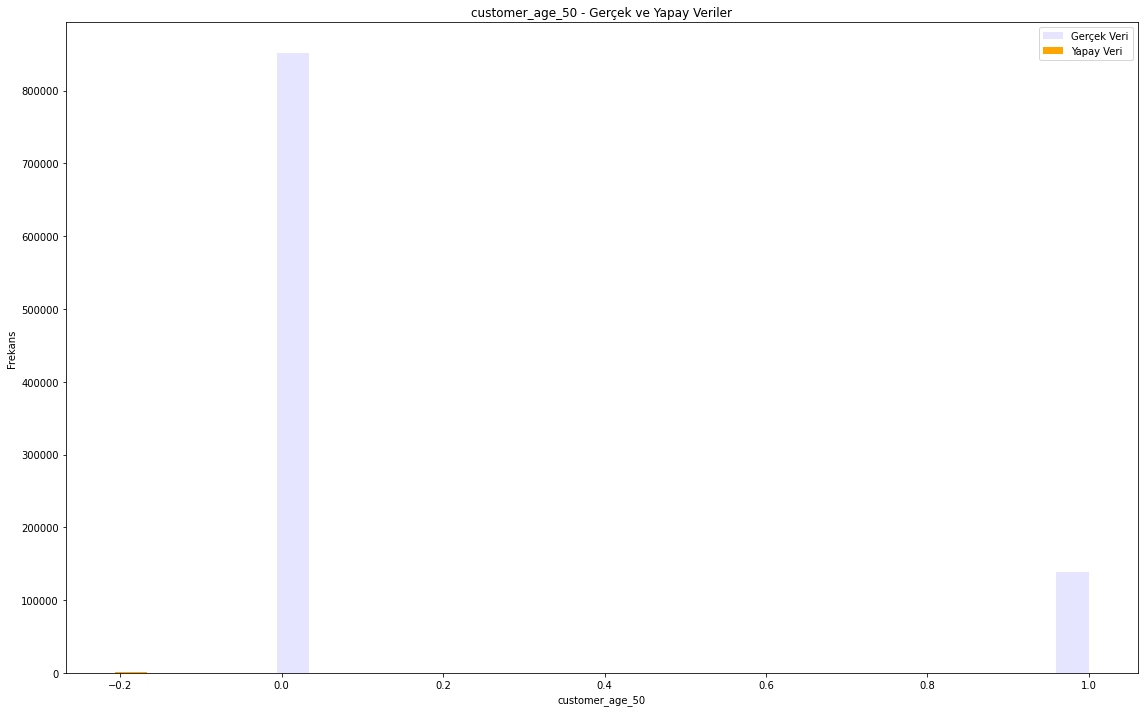

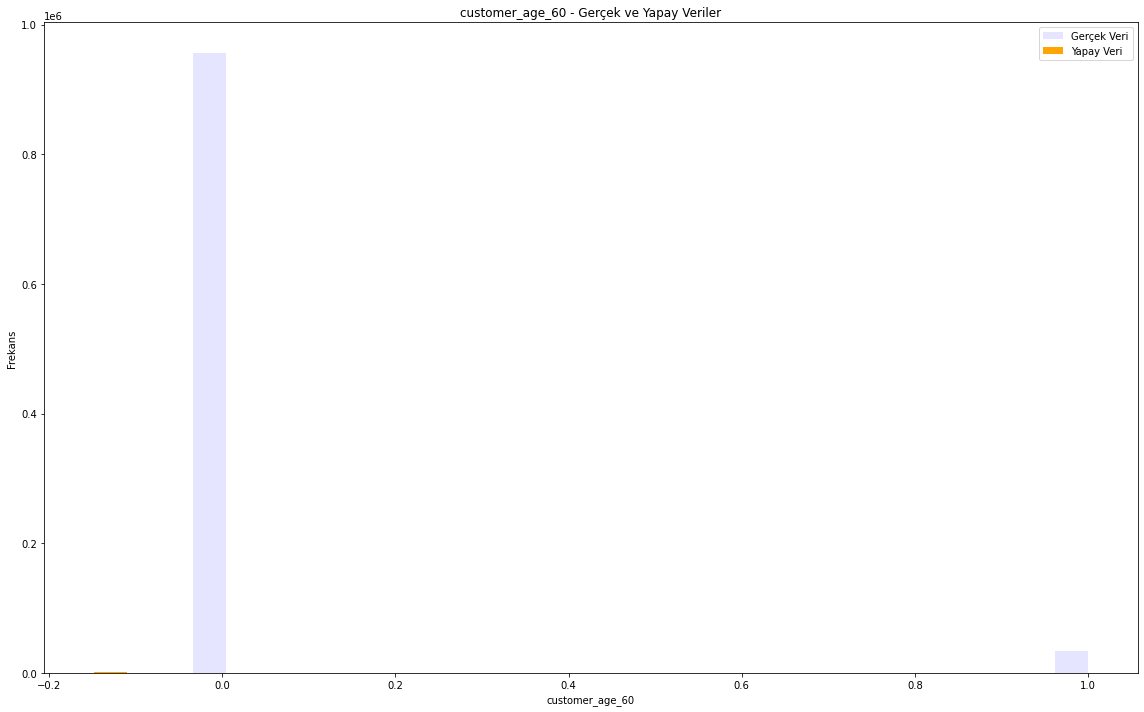

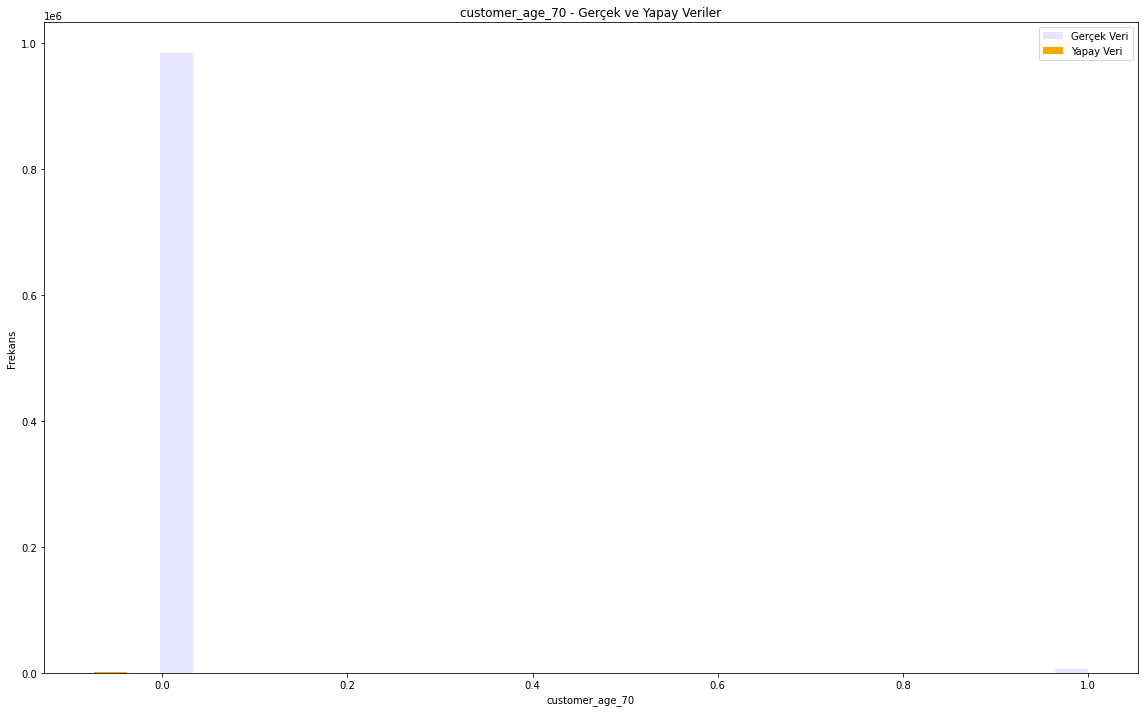

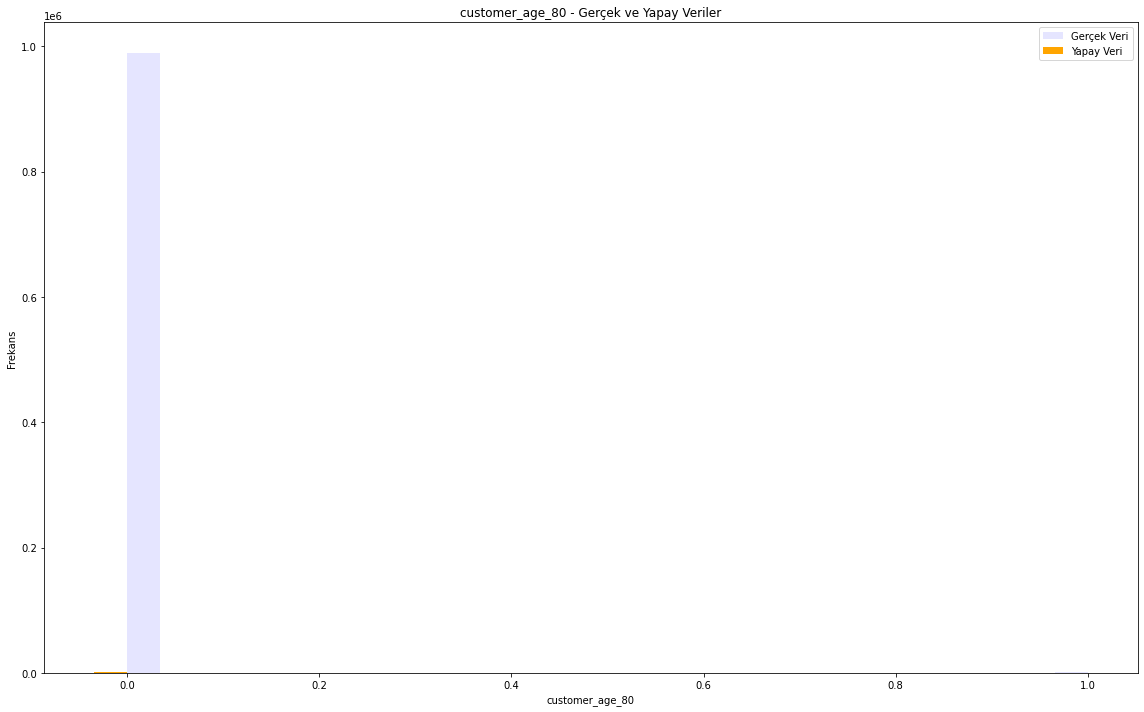

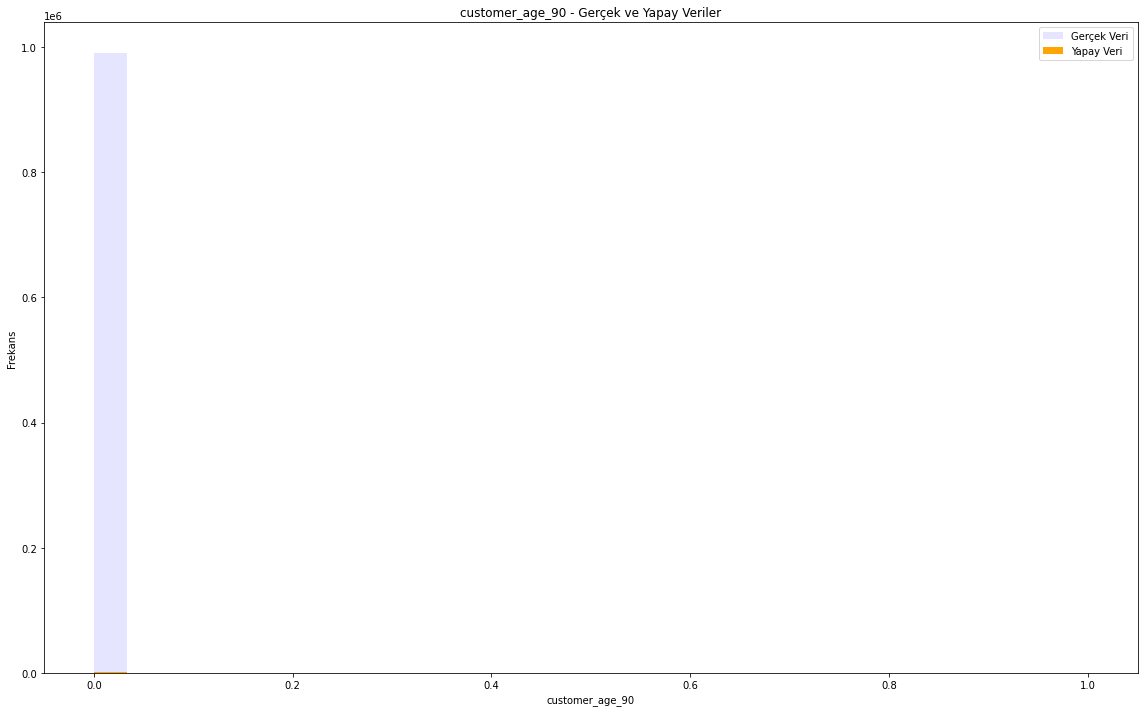

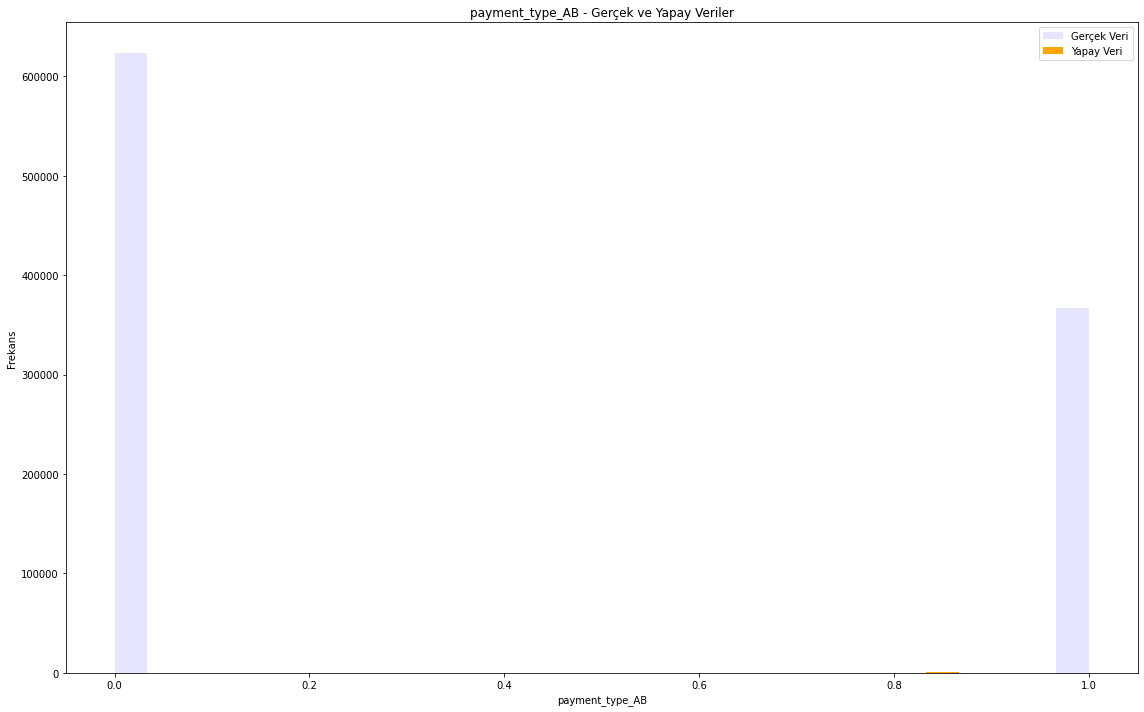

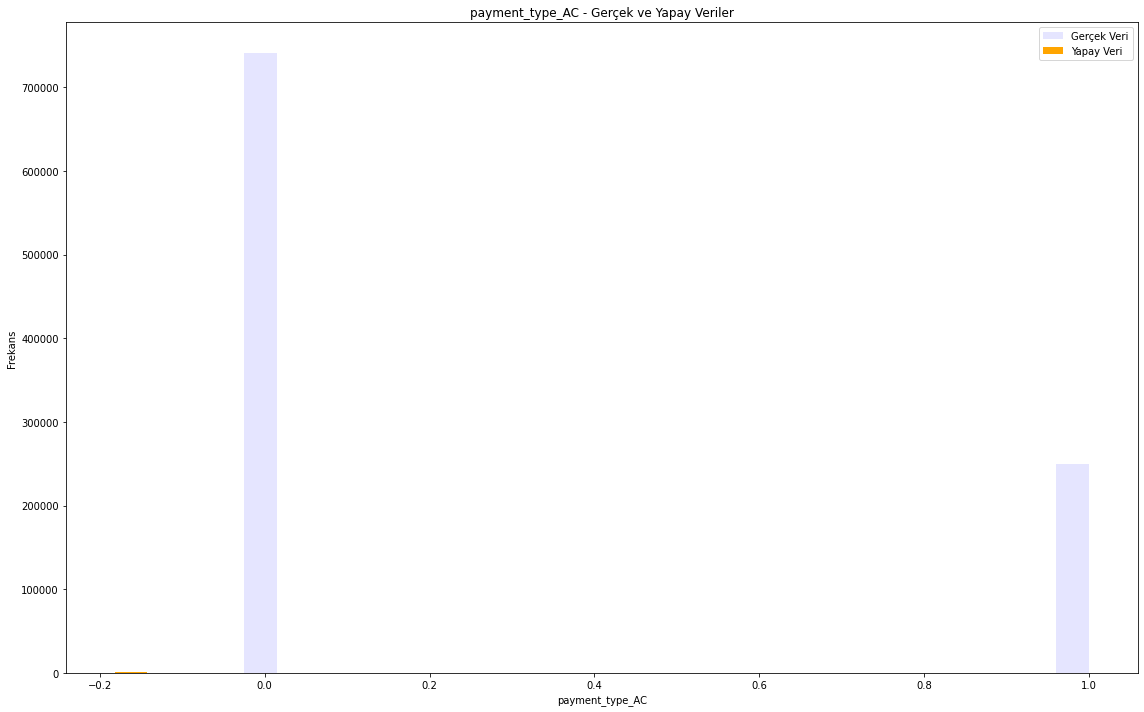

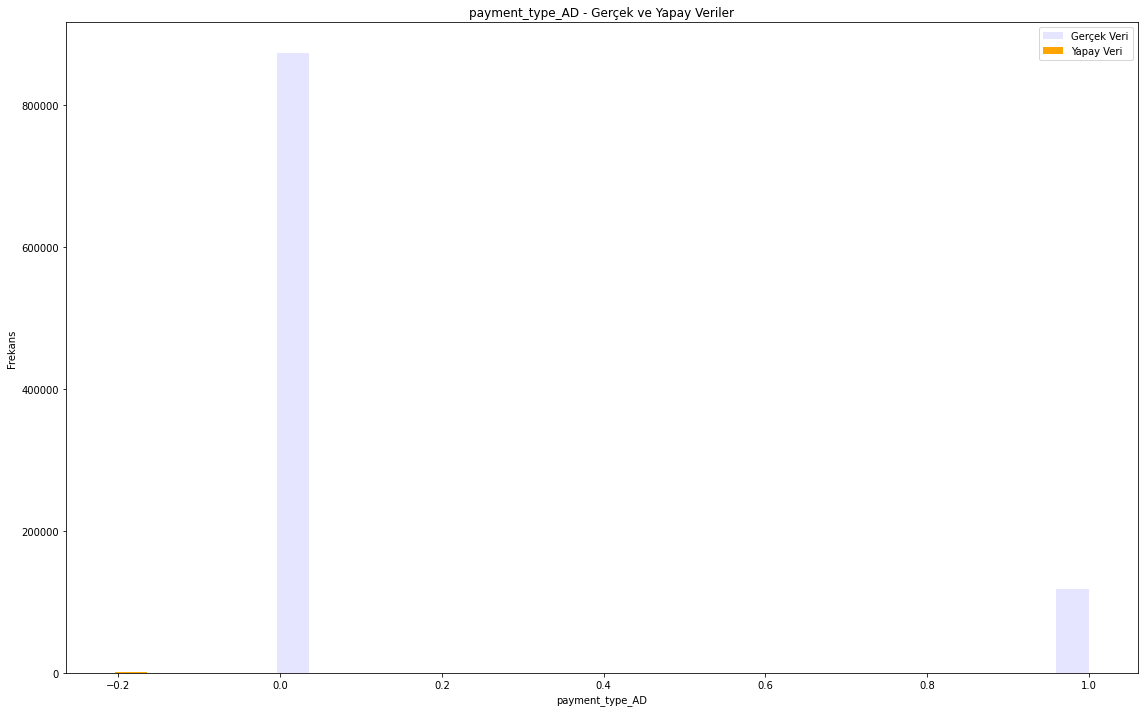

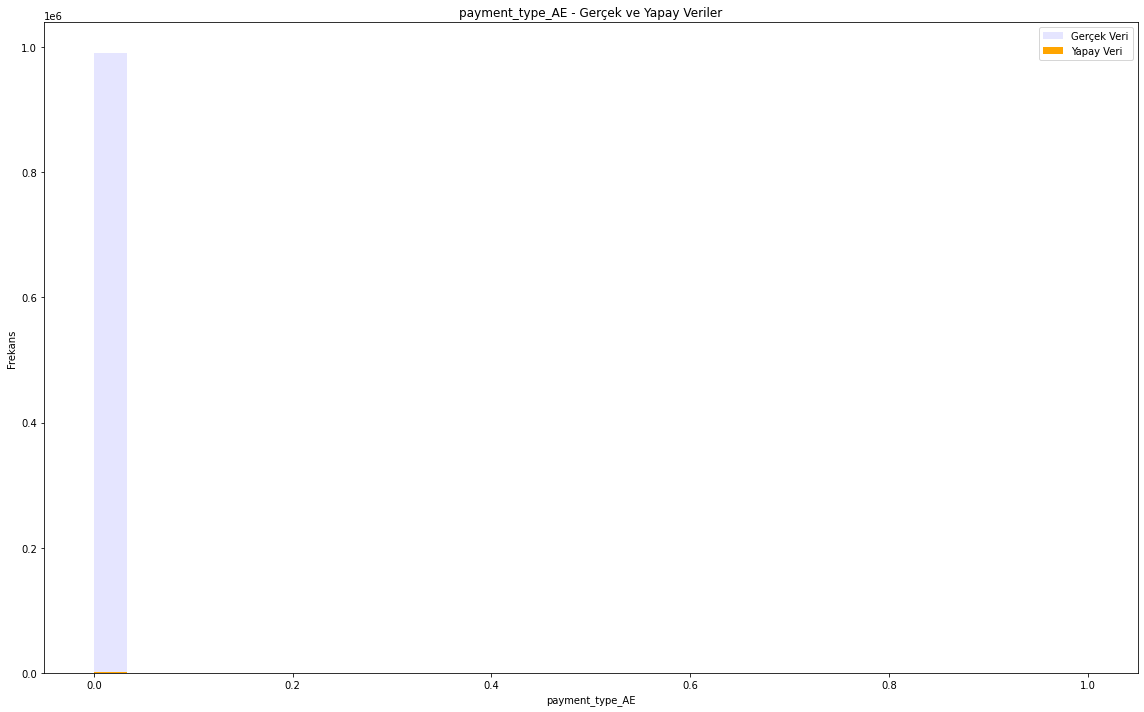

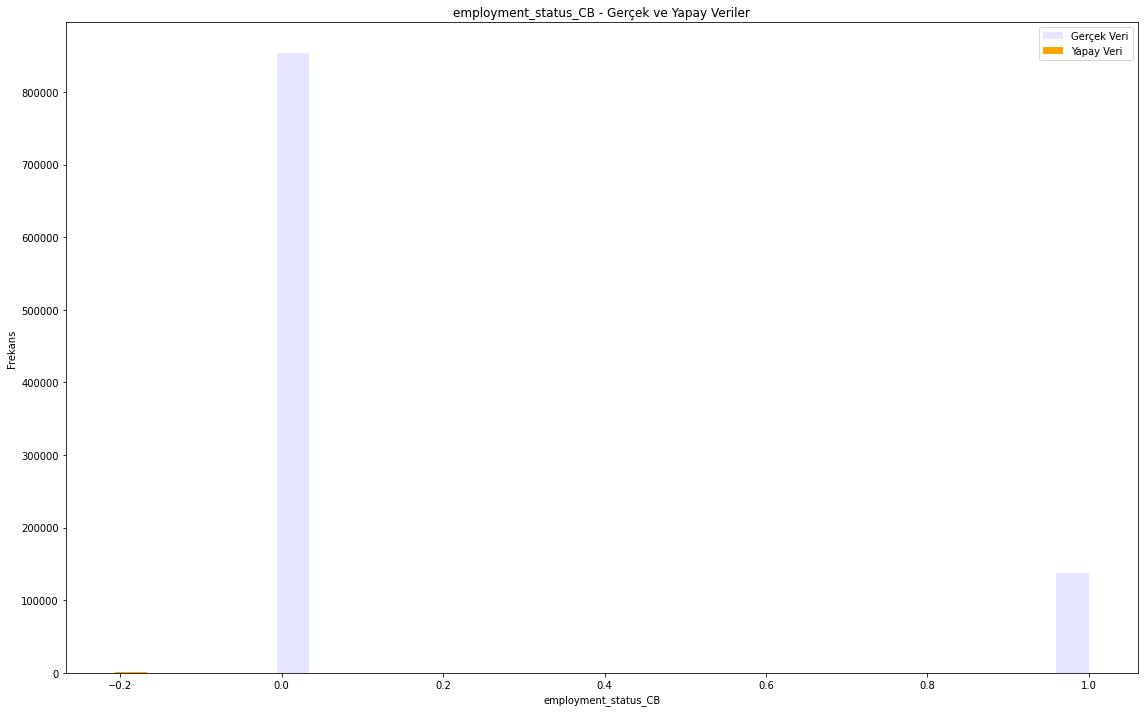

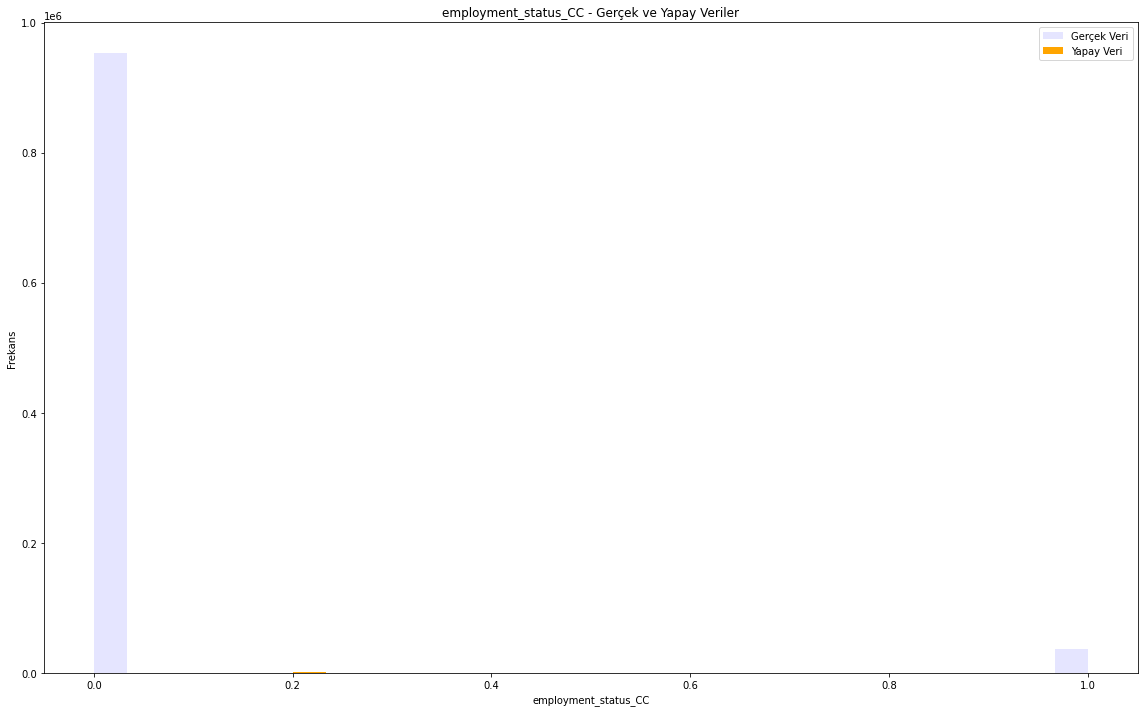

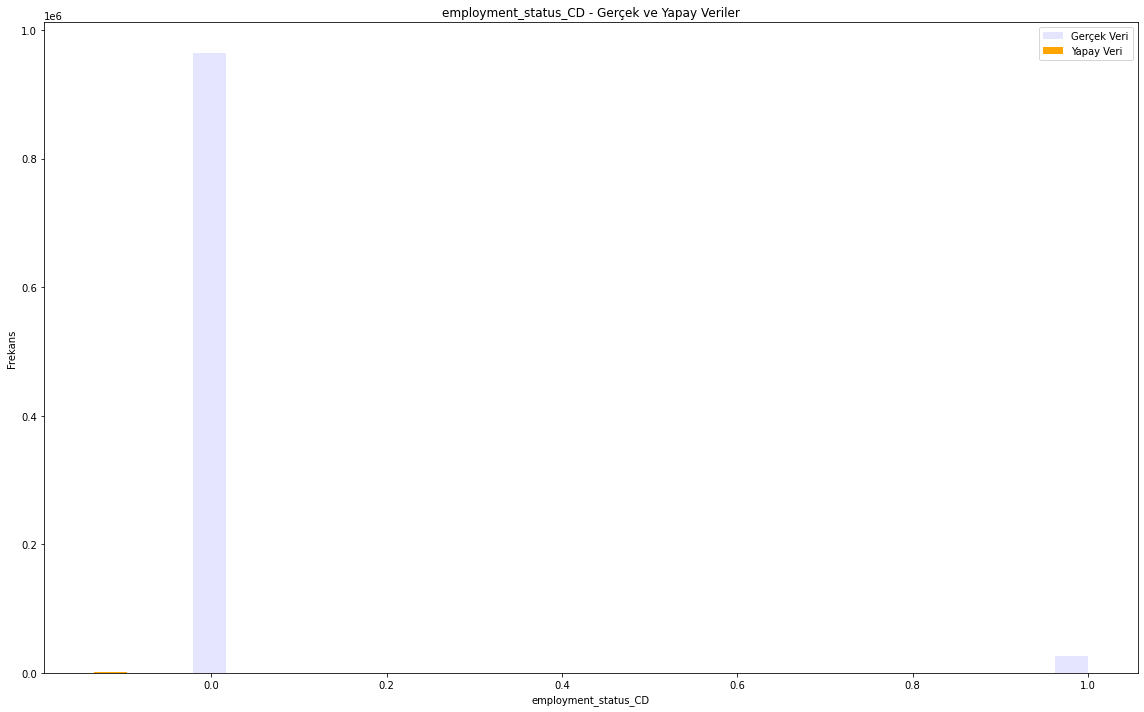

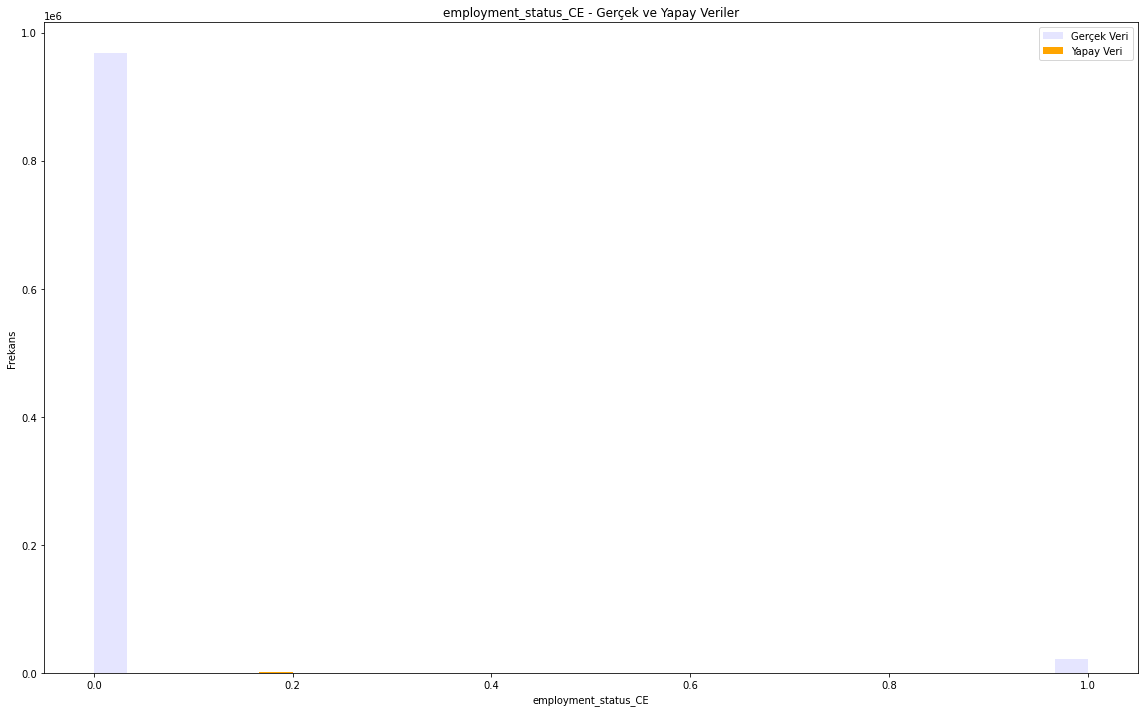

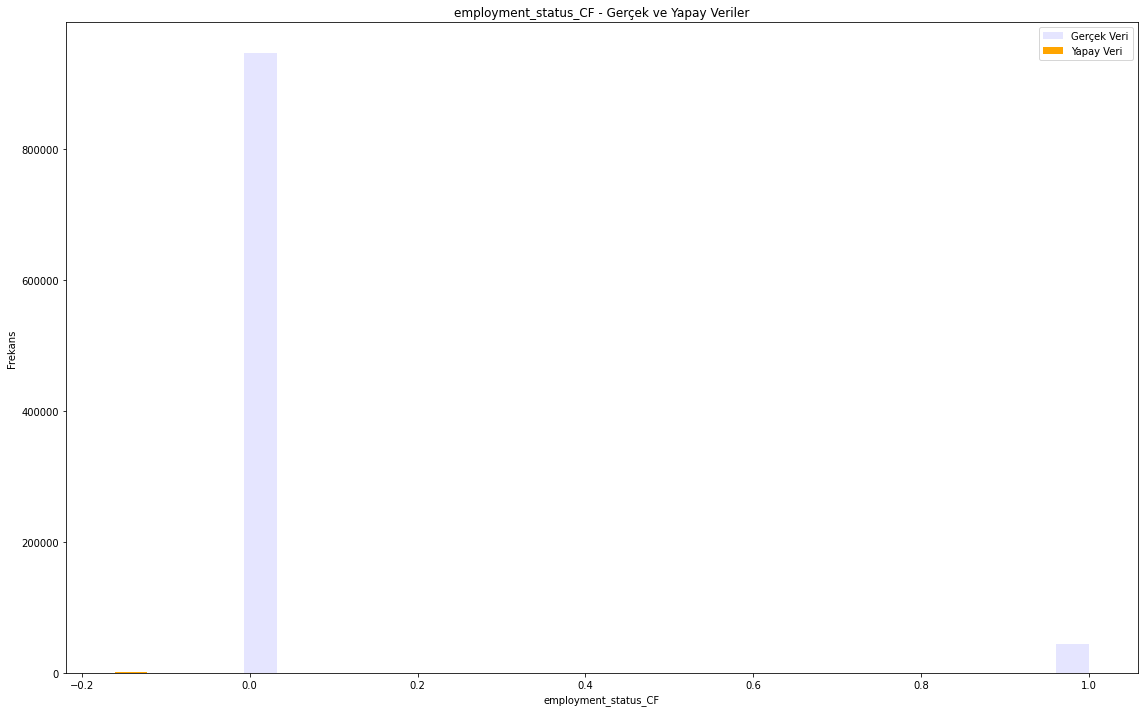

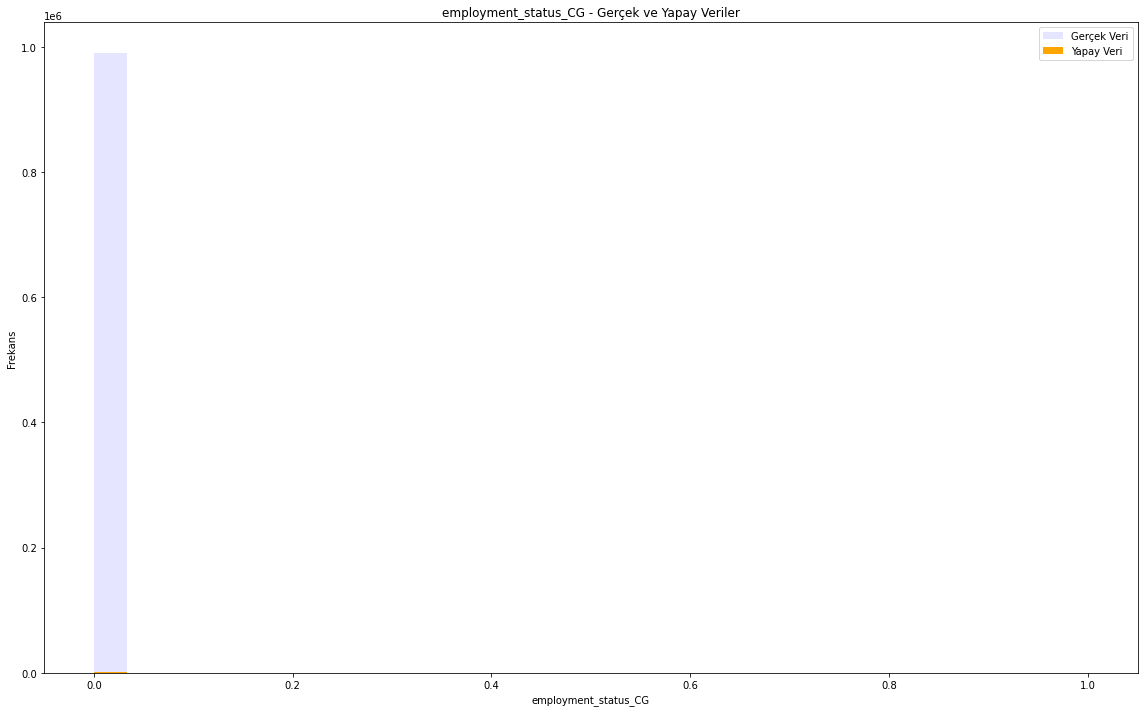

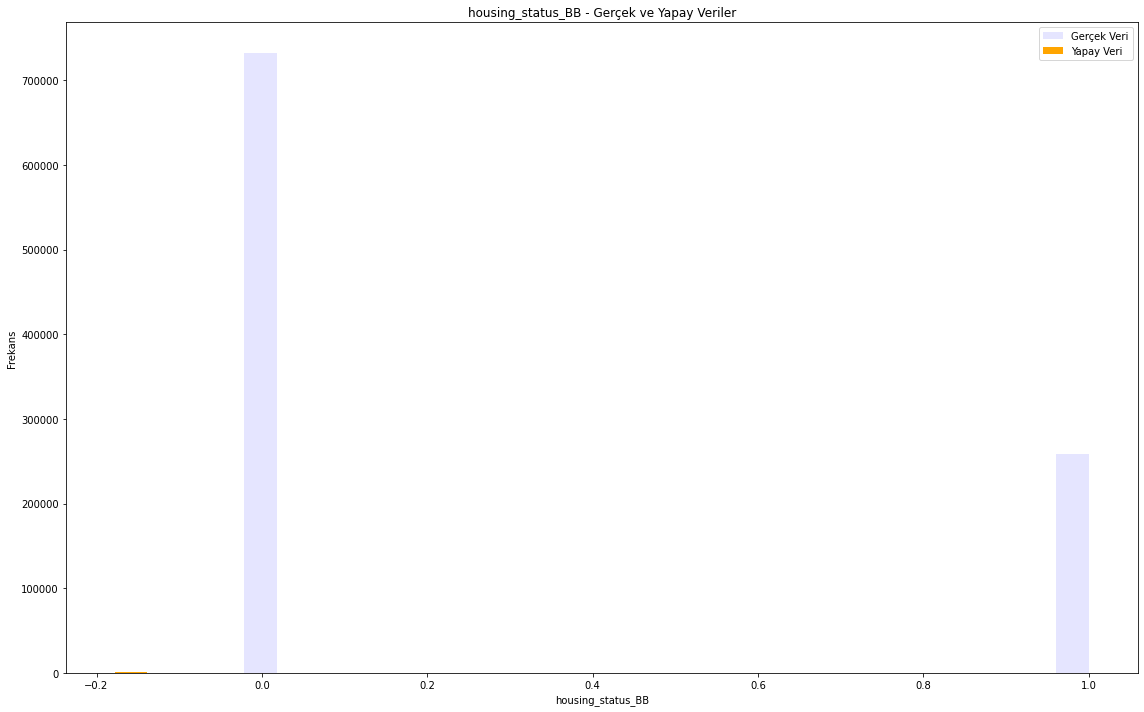

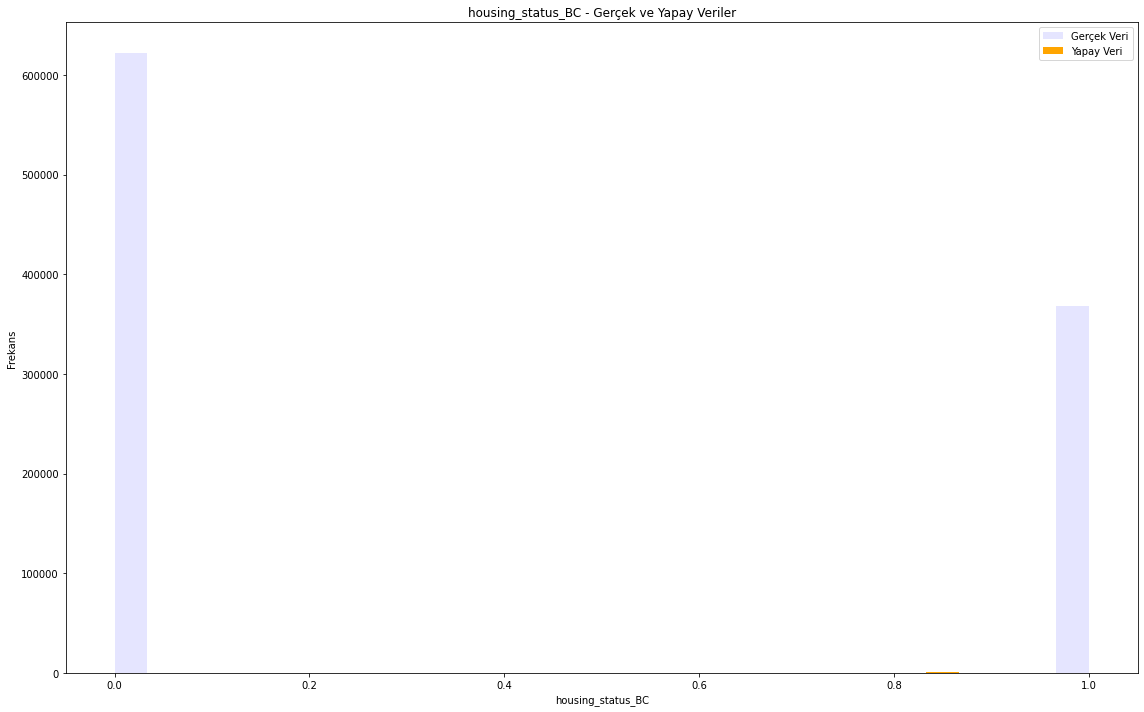

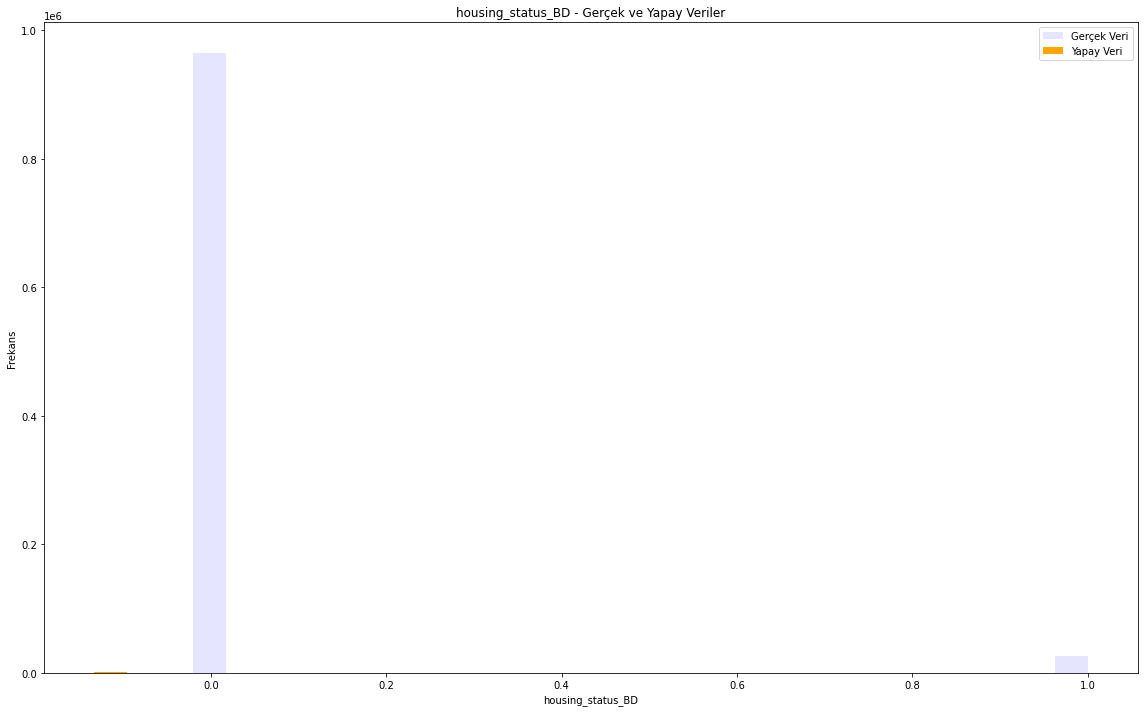

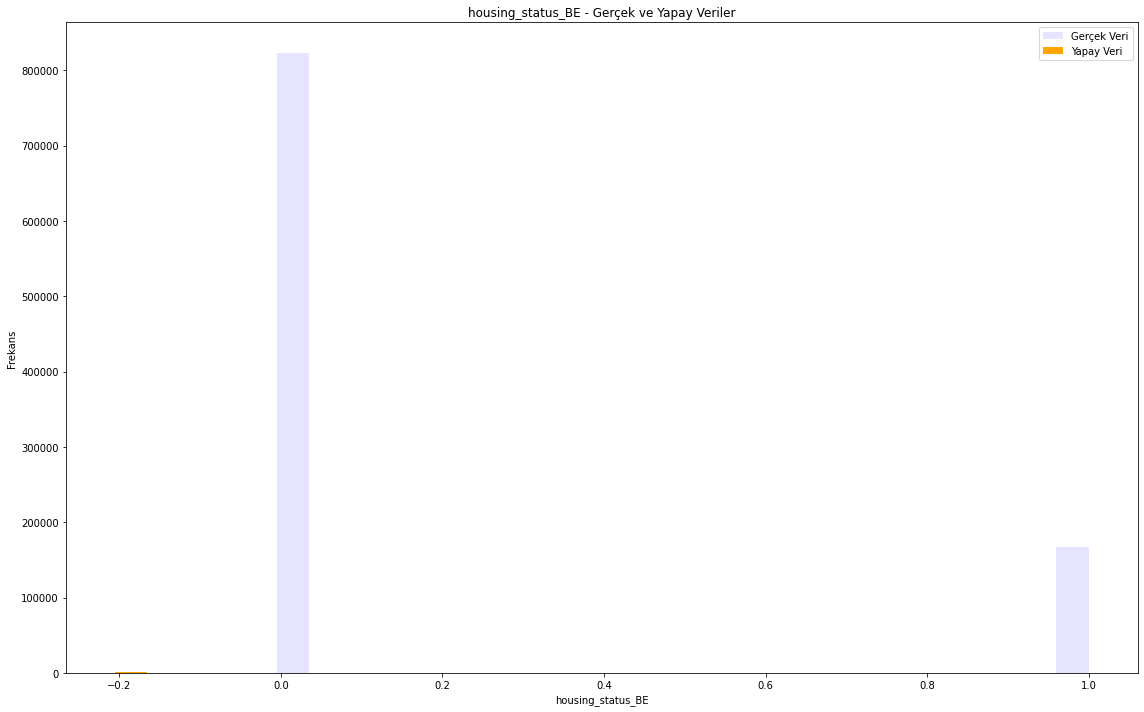

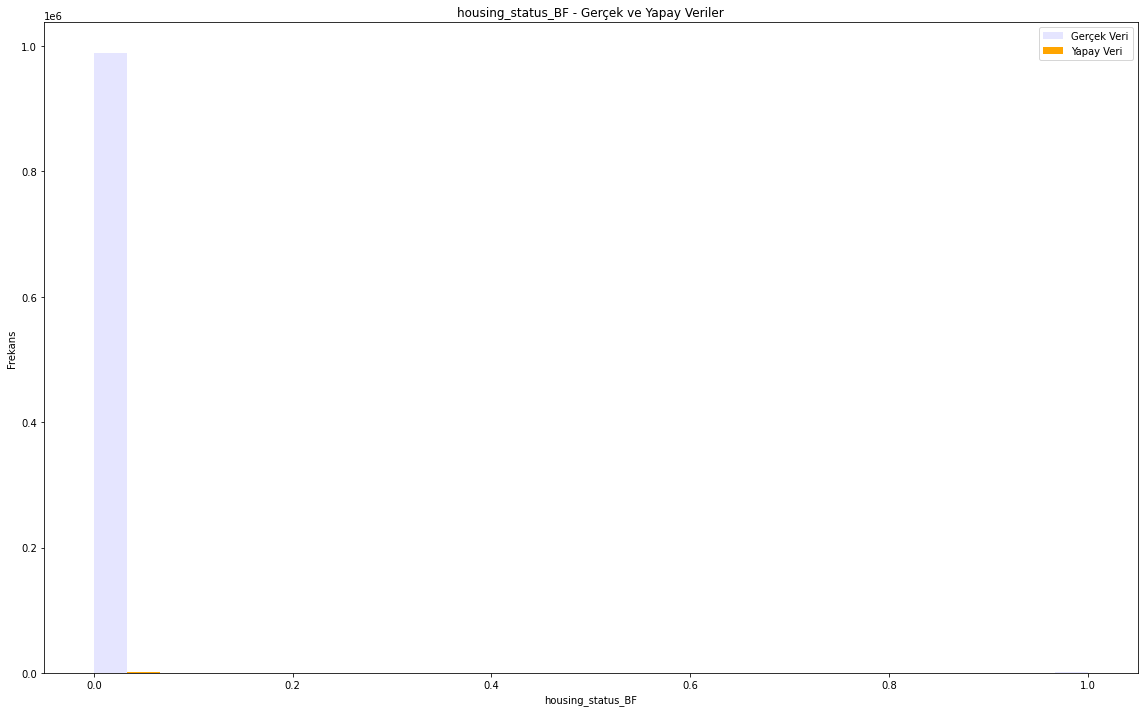

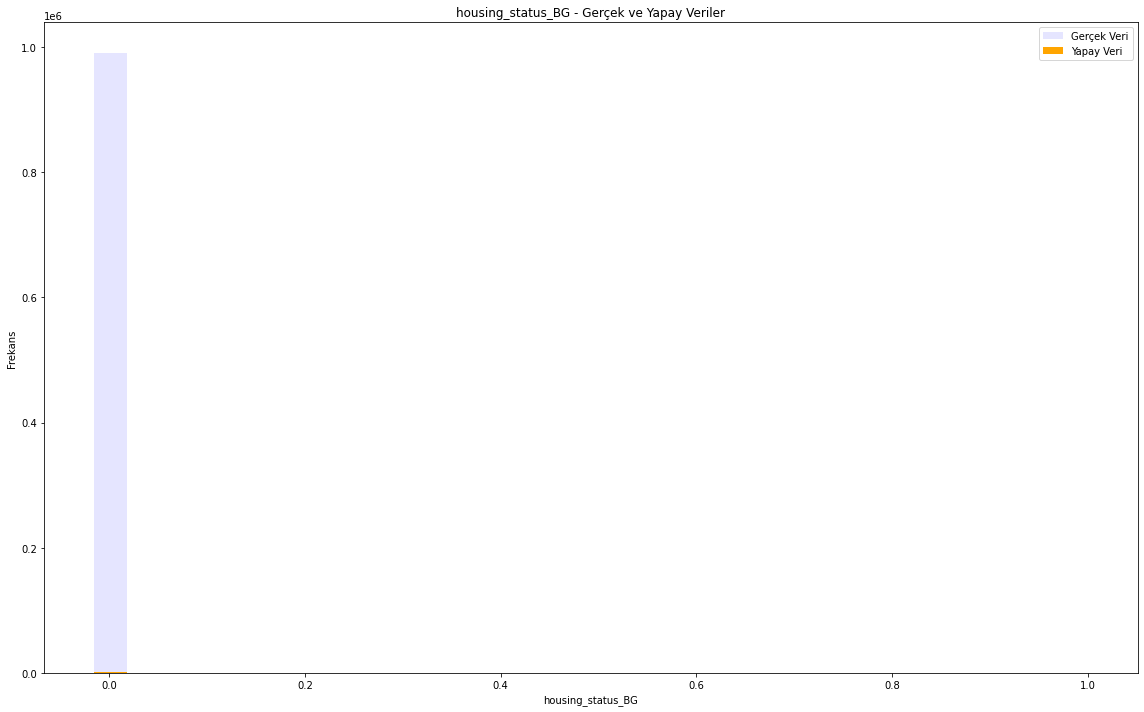

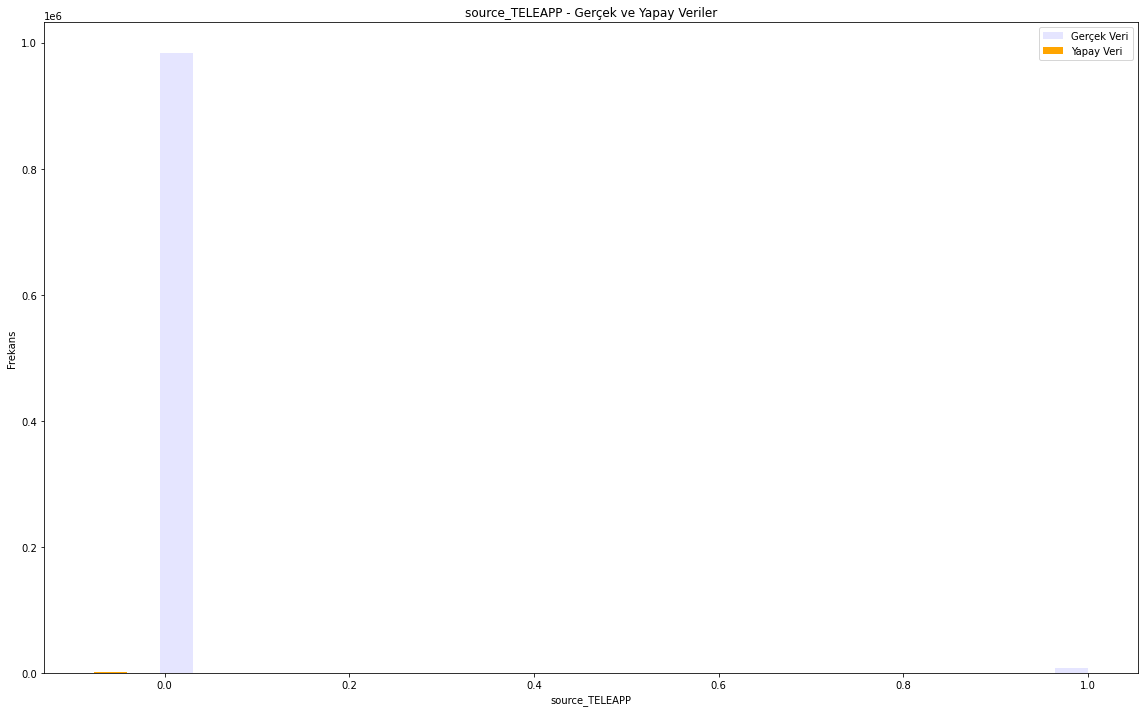

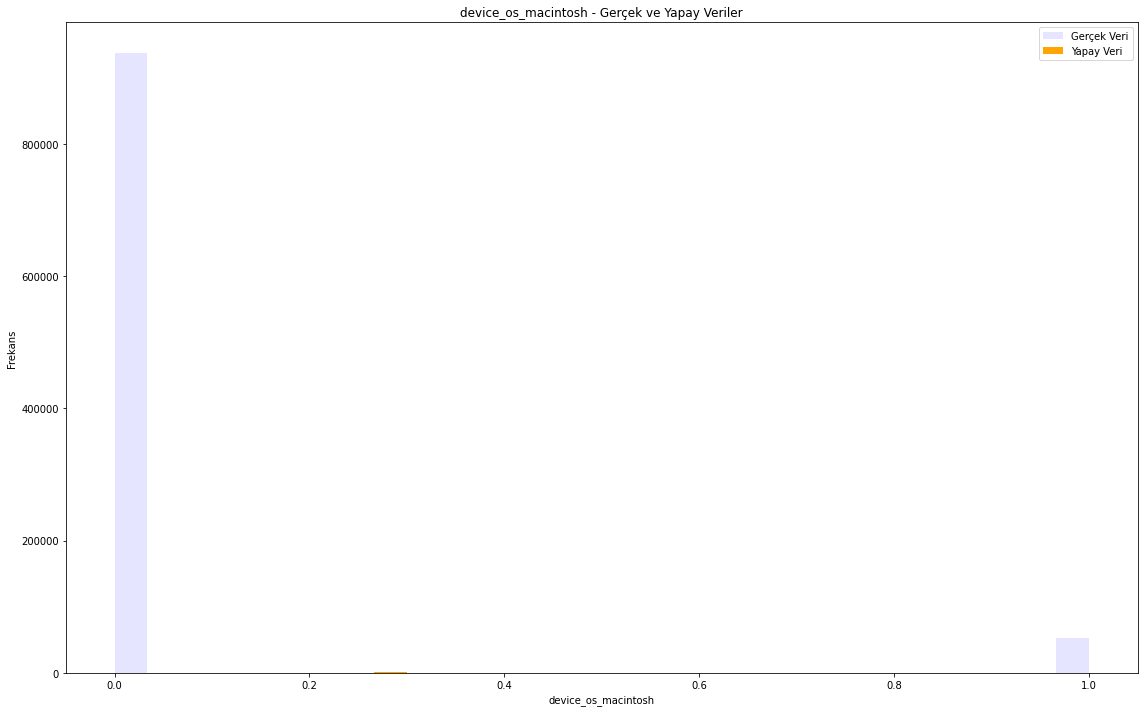

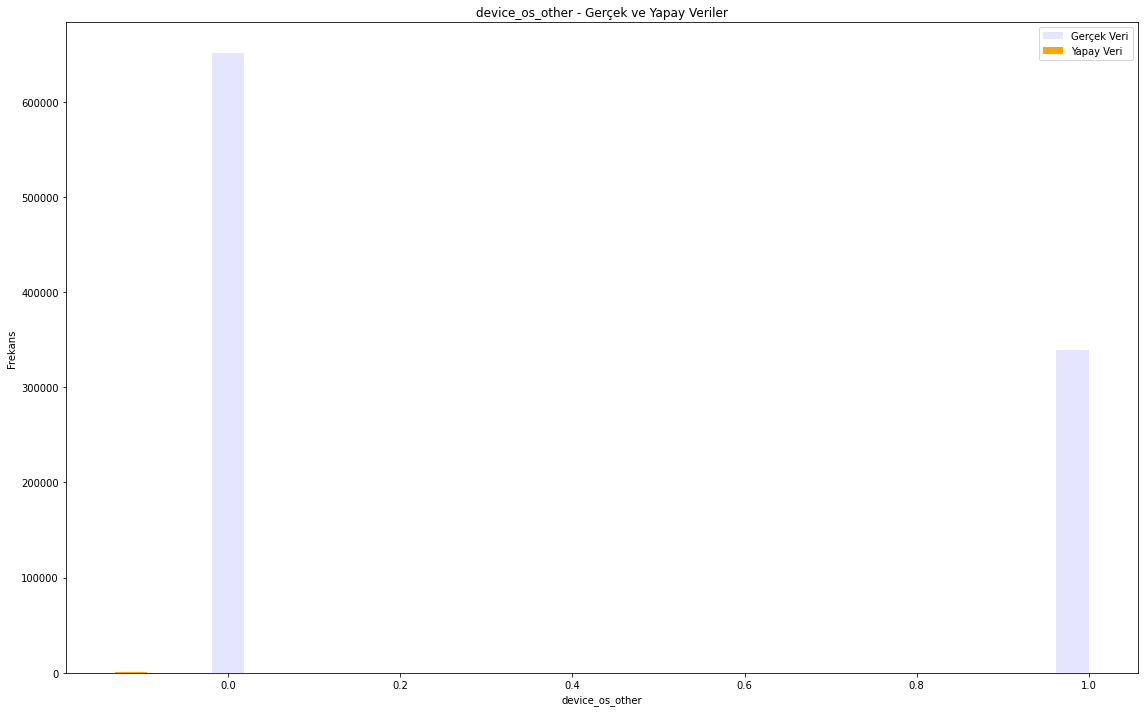

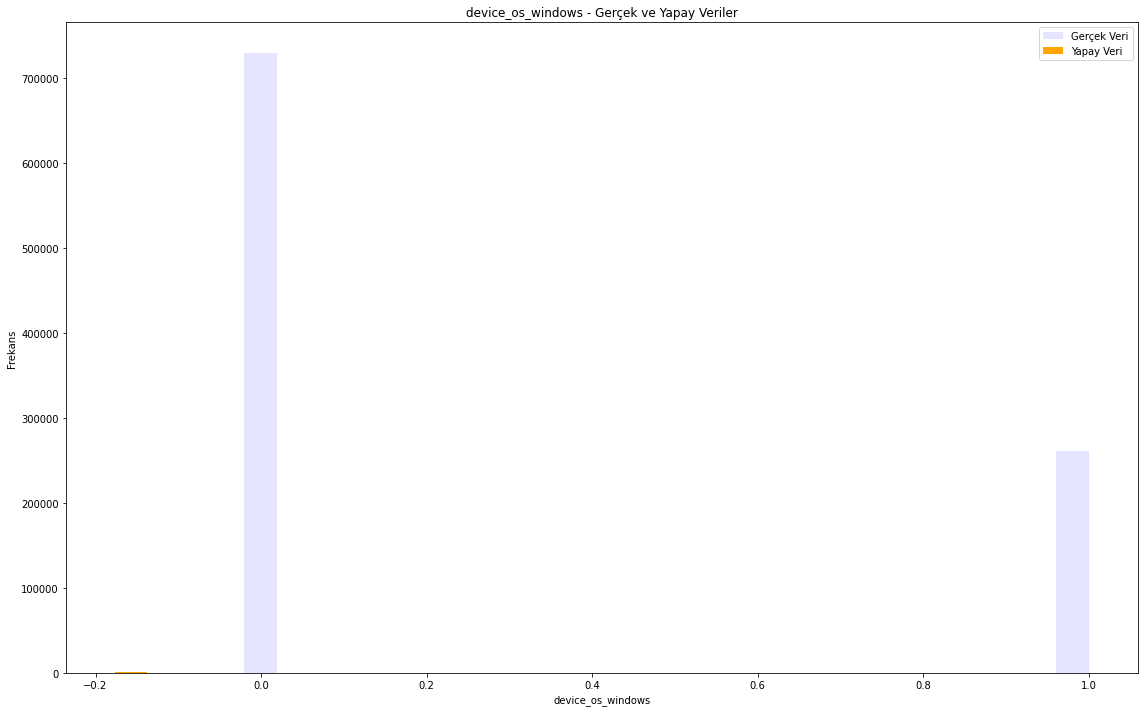

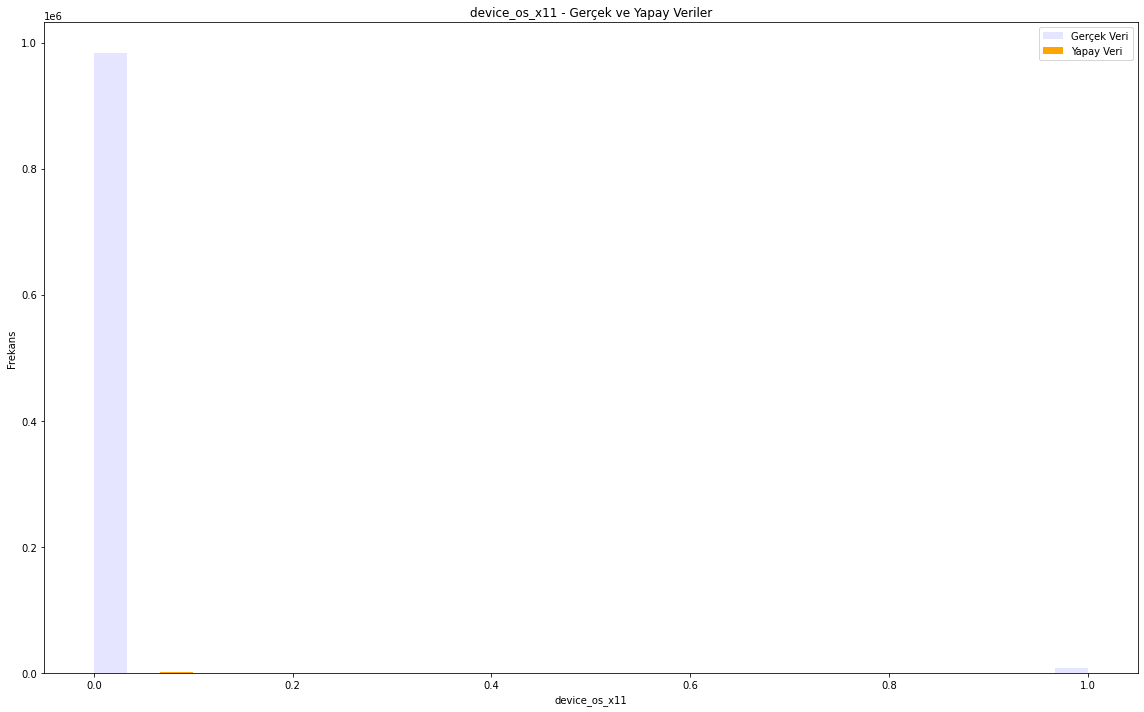

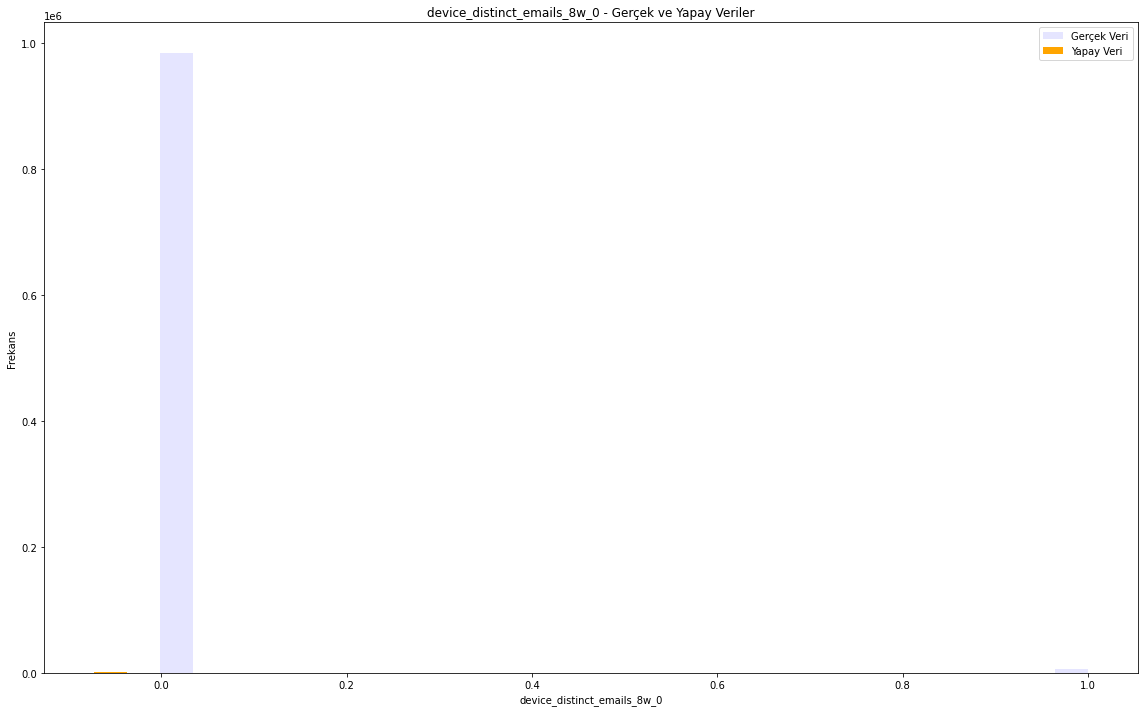

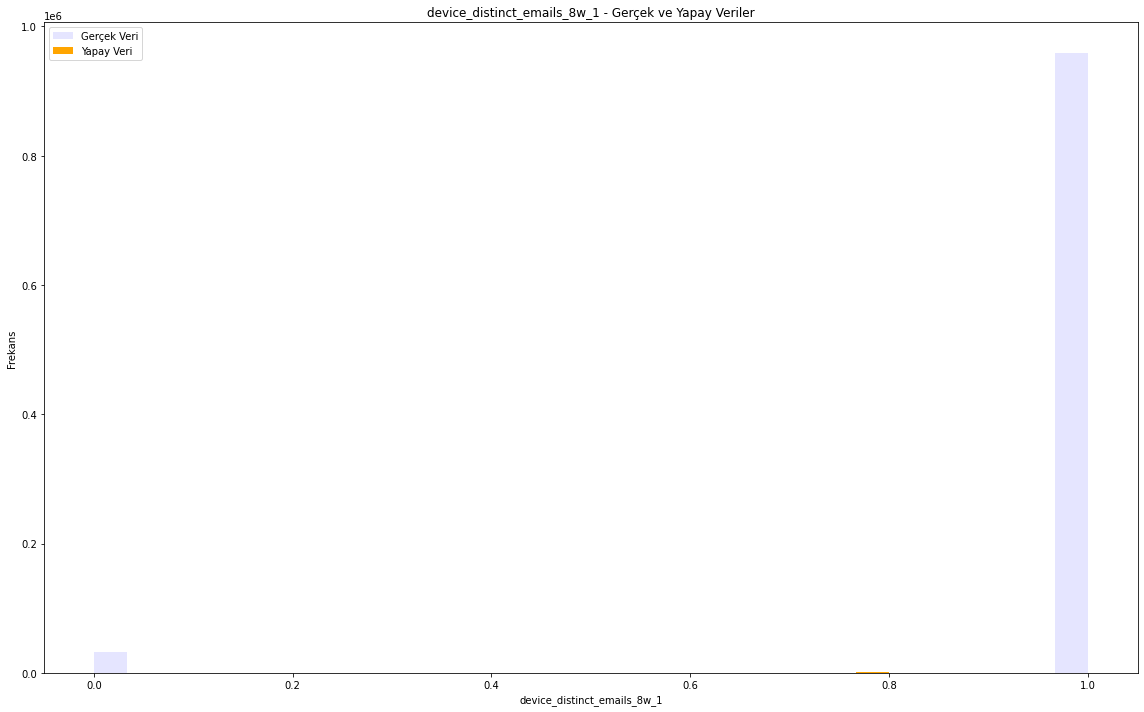

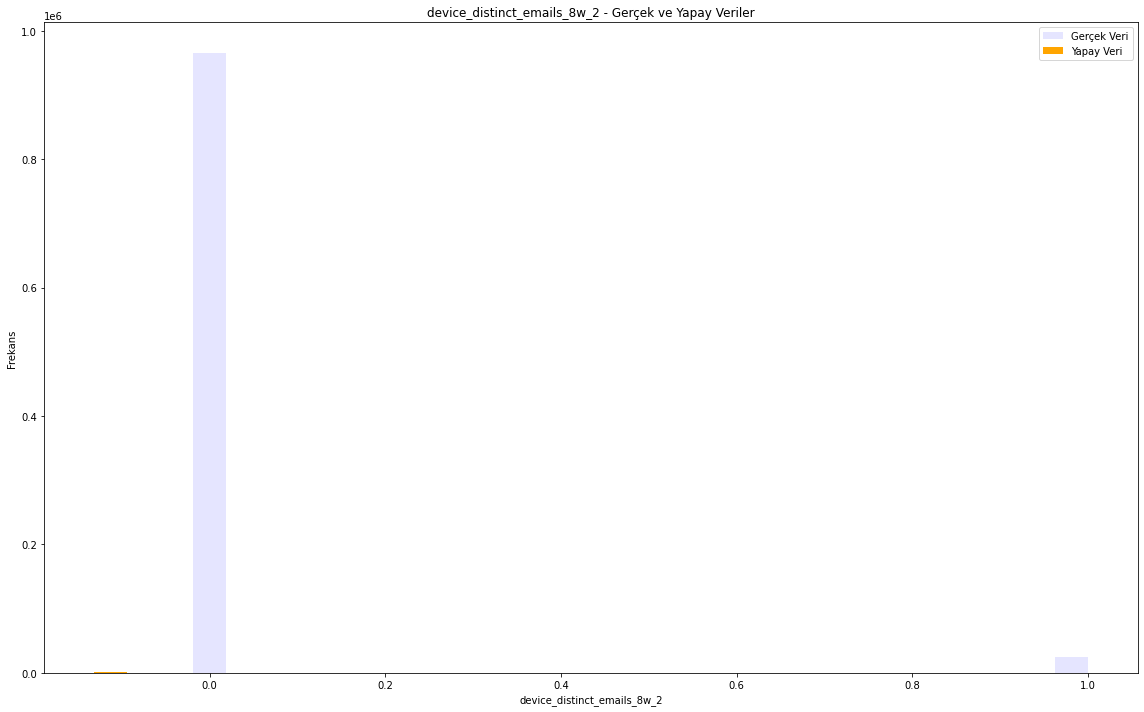

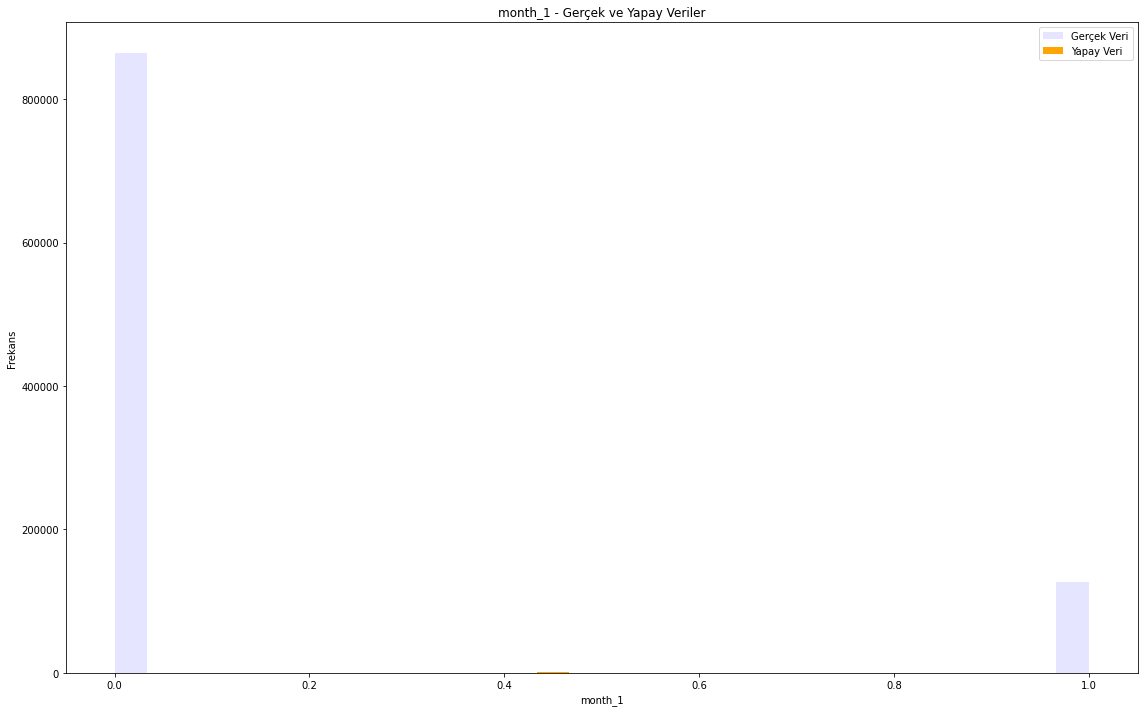

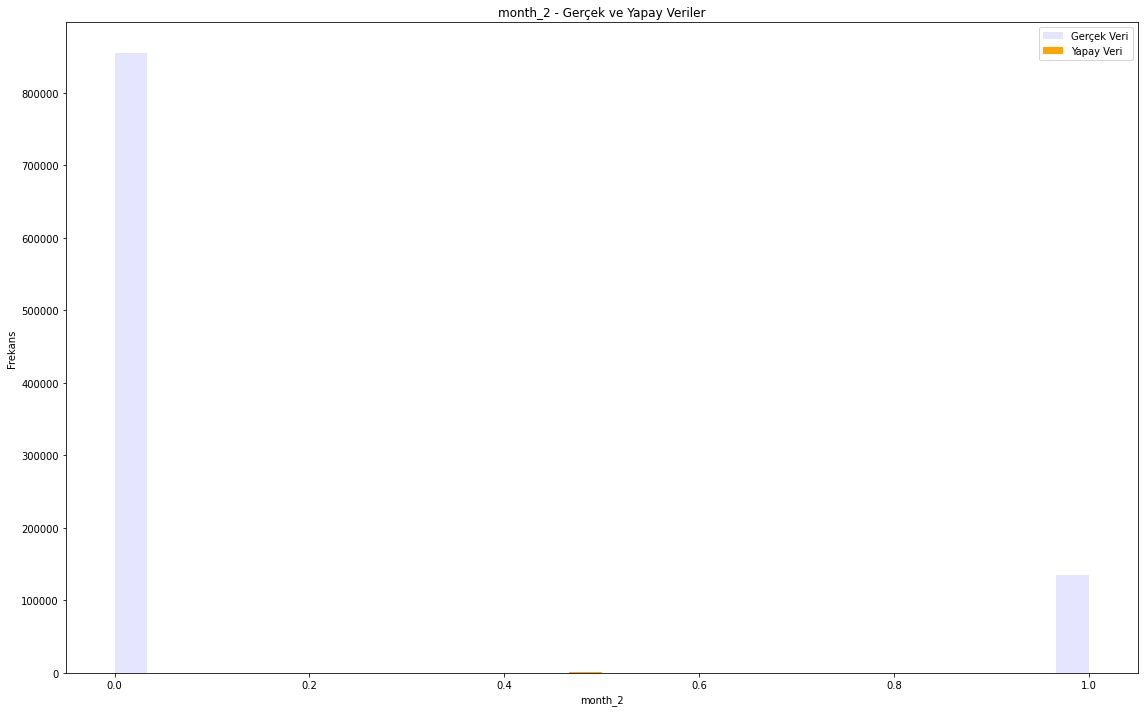

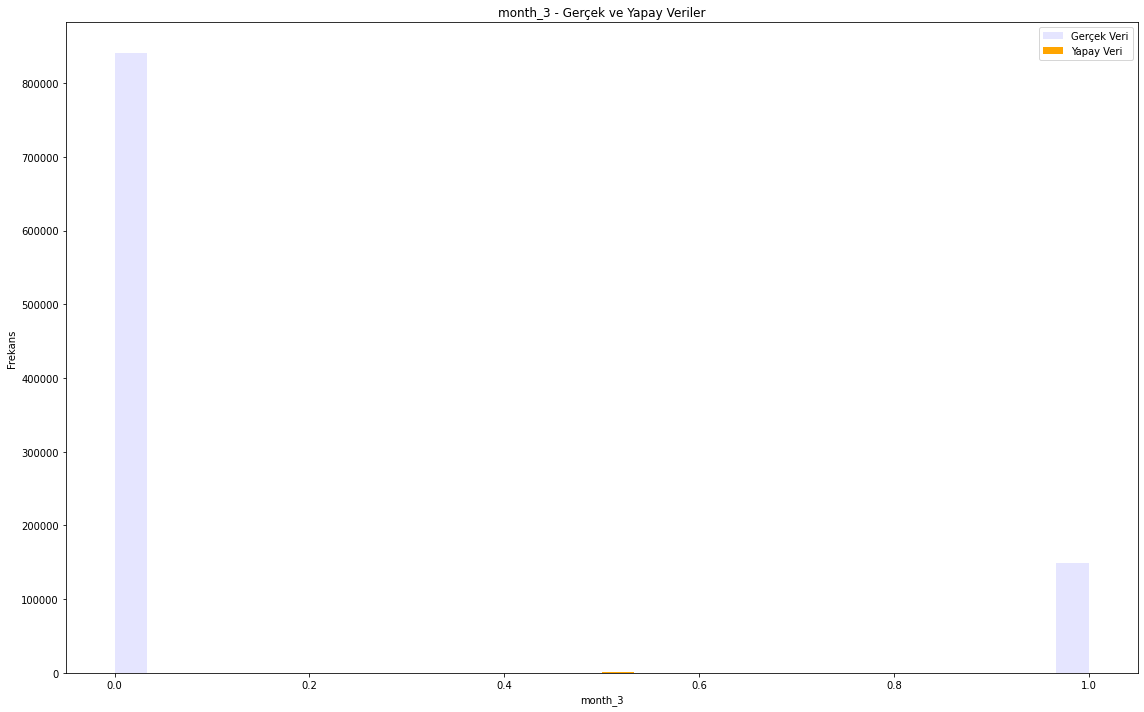

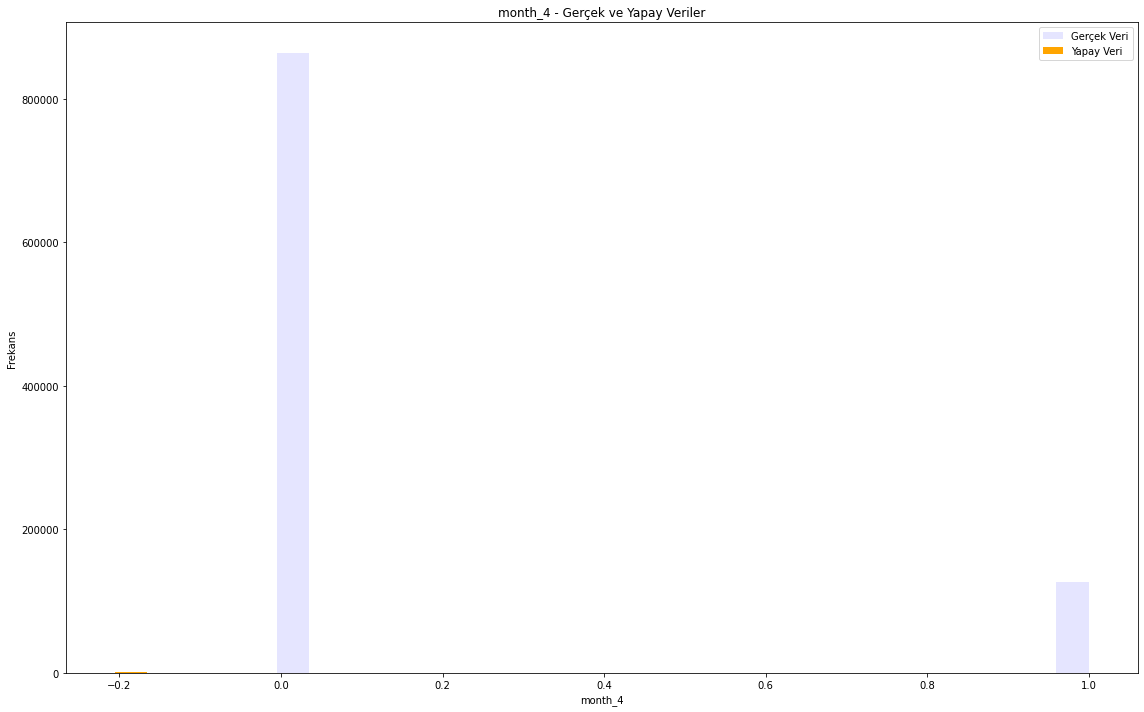

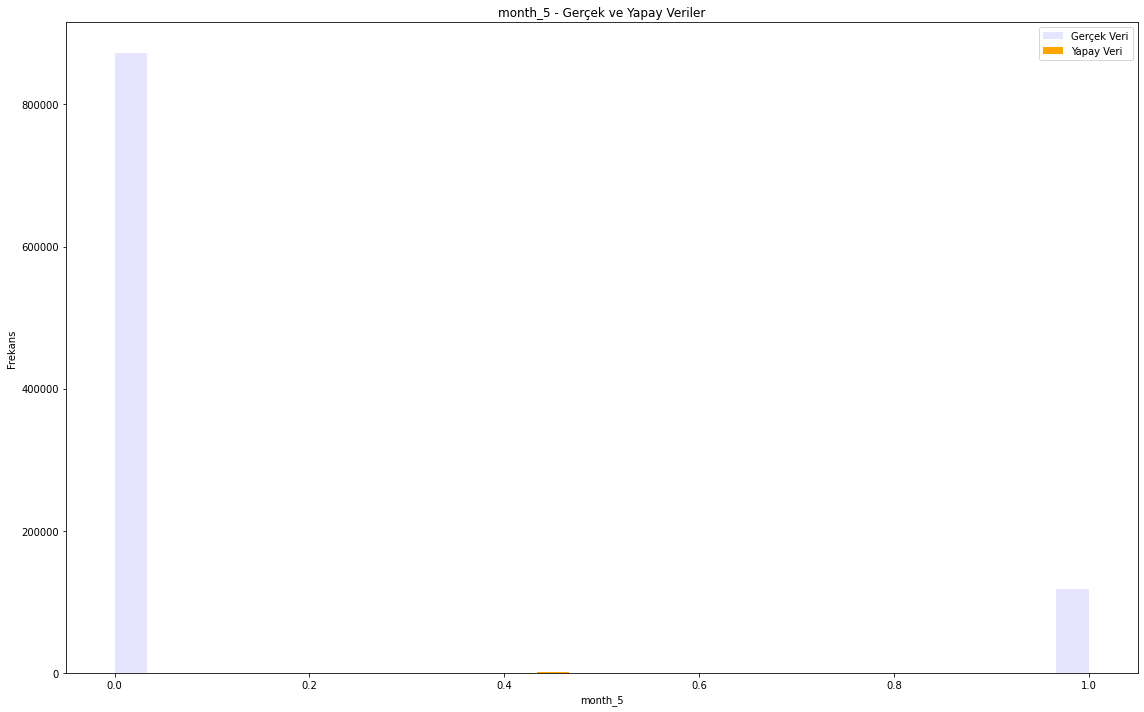

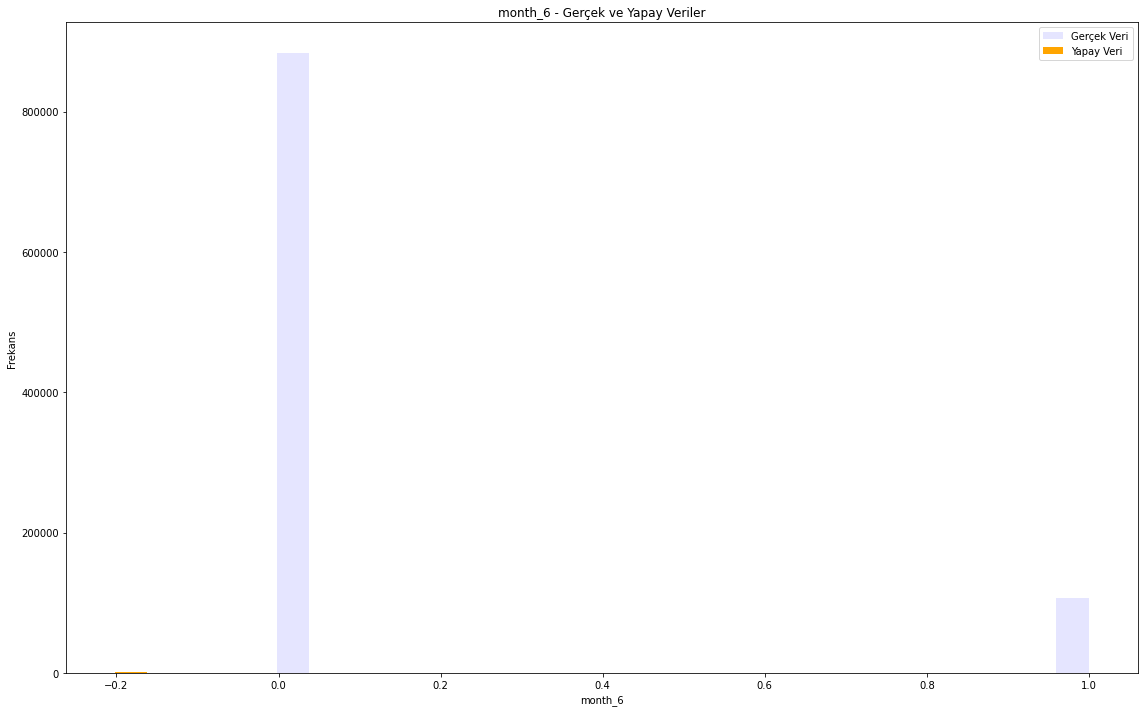

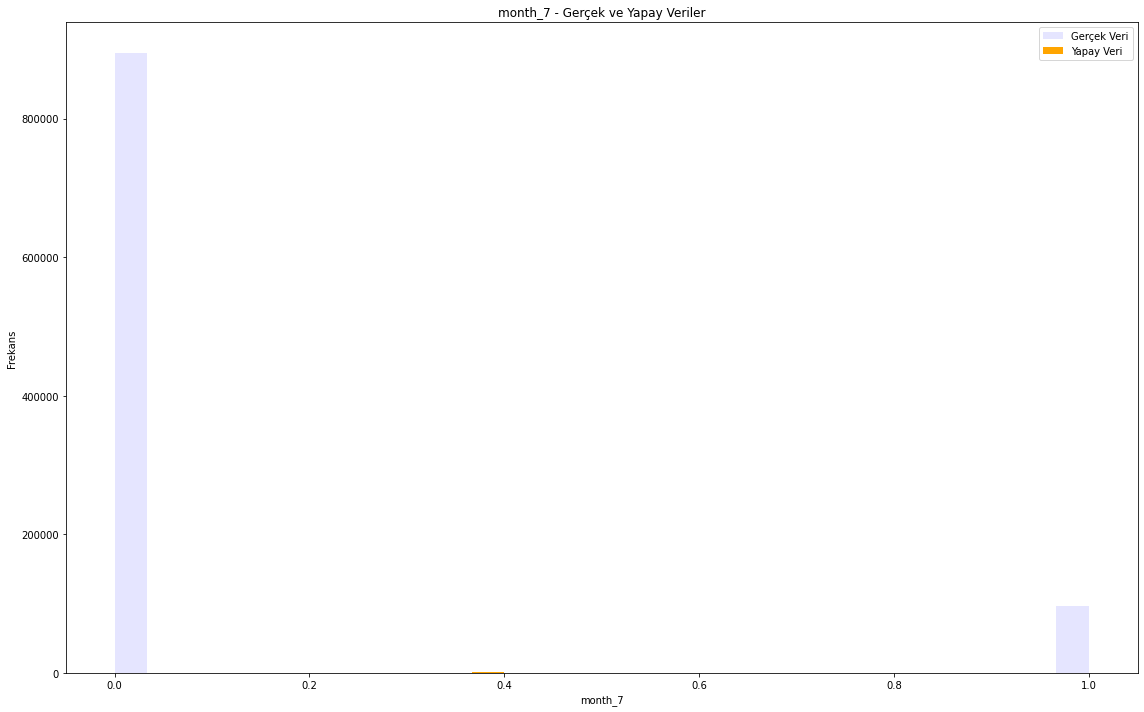

In [15]:
import matplotlib.pyplot as plt

# Özelliklerin adlarını alın (ilk sütun 'fraud_bool' hariç)
features = df.columns[:-1]

# Her bir özellik için histogramları tek bir tabloda çizme
for feature in features:
    plt.figure(figsize=(16, 10))
    
    # Histogram aralıklarını eşitle
    min_val = min(df[feature].min(), generated_df[feature].min())
    max_val = max(df[feature].max(), generated_df[feature].max())
    
    # Gerçek veri histogramı
    plt.hist(df[feature], bins=30, alpha=0.1, label='Gerçek Veri', color='blue', range=(min_val, max_val))
    
    # Yapay veri histogramı
    plt.hist(generated_df[feature], bins=30, alpha=1, label='Yapay Veri', color='orange', range=(min_val, max_val))
    
    plt.title(f'{feature} - Gerçek ve Yapay Veriler')
    plt.xlabel(feature)
    plt.ylabel('Frekans')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
